# script for processing rolling cv

# Runs the file containing general functions used in this script
## By default this is a file called "methane_functions.r" in the working directory of this script
## Do NOT change the working directory at any point while using this script.

In [3]:
methaneFunctions<-paste(getwd(),"/methane_functions.r",sep="")
methaneFunctions
if (file.exists(methaneFunctions)){
    source(methaneFunctions)
} else {
    print("manually correct the location and/or name of methane_functions.r")
}

[1] "/home/pleocavee/Documents/github/SensorDataProcessing/rriv_methane/methane_functions.r"

# 0. Load packages used

In [25]:
# Package names
packages <- c("dplyr", "doBy", "lubridate", "ggplot2", "Hmisc", "zoo", "viridis")
packageHandler(packages)


Attaching package: ‘doBy’


The following object is masked from ‘package:dplyr’:

    order_by


Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## Function to calculate rolling CV for warm-up detection
Starting with using the summary data for calculations

In [5]:
calculateCV<-function(processed_data, dataType, lc=loggerCount, ll=loggerList){
    temp_cv<-data.frame()
    calculated_cv_list<-vector("list", lc)
    for(i in 1:lc){
        df<-subset(processed_data, logger==ll[i] & type==dataType)

        measurementCycles<-unique(df$measurementCycle)
        for(i in 1:length(measurementCycles)){
            temp<-subset(df,measurementCycle==measurementCycles[i])
            temp$roll_mean<-rollapply(data=temp$ch4_raw,width=4,align=c("right"),FUN=mean,fill=NA)
            temp$roll_sd<-rollapply(data=temp$ch4_raw,width=4,align=c("right"),FUN=sd,fill=NA)
            temp$roll_cv<-temp$roll_sd/temp$roll_mean #optionally multiply by 100 for %
            temp_cv<-bind_rows(temp_cv,temp)
        }
        calculated_cv_list[[i]]<-temp_cv
    }
    return(bind_rows(calculated_cv_list))
}

## Function to create basic plots of burst vs raw methane reading colored by measurement cycle

In [6]:
cycleVsCH4_plots<-function(processed_data, dataType, lc=loggerCount, ll=loggerList){
    plots<-vector("list", lc)
    names(plots)<-ll
    for(i in 1:lc){
        data<-subset(processed_data, logger==ll[i] & type==dataType)

        plots[[i]]<-ggplot(data, aes(burstCycle, ch4_raw))+
            geom_point(aes(color=measurementCycle))+scale_color_viridis()+
            ggtitle(paste("Logger: ", ll[i], "\nData type: ", dataType))
    }
    return(plots)
}

## Function to plot rolling cv vs burst cycle and colored by measurement cycle

In [7]:
rollCV_plots<-function(parseDataCV, ll=loggerList, lc=loggerCount){
    plots<-vector("list", lc)
    names(plots)<-ll
    for(i in 1:lc){
        data<-subset(parseDataCV, logger==ll[i])
        plots[[i]]<-ggplot(data, aes(burstCycle, roll_cv))+
        geom_point(aes(color=as.integer(measurementCycle)))+
        scale_y_log10()+scale_color_viridis()+
        ggtitle(paste("Rolling CV for Logger: ",ll[i]))
    }
    return(plots)
}

## Function to calculate the mean of rolling cv above provided burst for each measurement cycle to determine target cv for methane driver

In [8]:
mean_cv_burst<-function(parseDataCV, burstCycleStart, ll=loggerList, lc=loggerCount){
    mean_na<-function(x){mean(x,na.rm=TRUE)}
    
    temp_mean<-vector("list", lc)
    for(i in 1:lc){
        df<-subset(parseDataCV, logger==ll[i] & as.integer(burstCycle)>=burstCycleStart)
        
        if(max(df$measurementCycle) > 2){
            temp_mean[[i]]<-summaryBy(roll_cv~measurementCycle,df,FUN=c(mean_na))
            temp_mean[[i]]$logger<-unique(df$logger)
            temp_mean[[i]]$deployed_at<-lubridate::as_datetime(unique(df$deployed_at))
        }
    }
    return(bind_rows(temp_mean))
}

# RUN

# TODO: need the lines for initial concatenation of data in relevant directory

In [9]:
directory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230309_1000ppm_/RRIV"

In [19]:
outputDir<-paste(directory,"_output/",sep="")
newDir(outputDir)

Output directory, ~/Desktop/data/Methane Calibration/concentration_tests/20230309_1000ppm_/RRIV_output/, already exists


In [13]:
processed_data<-concat_dirs(directory, read_rriv_CSV, minFileSize=500)
processed_data<-process_rriv_columns(processed_data)

loggerList<-unique(processed_data$logger) #save each individual logger
loggerList

loggerCount<-length(loggerList) #how many loggers
loggerCount

[1] "Dataframe generated, manually process column types if necessary"


[1] 21010 21011 kcdev 21012 21013 21001
Levels: 21001 21010 21011 21012 21013 kcdev

[1] 6

### Create plots of raw data and summary data burstCycle vs methane and save them

In [20]:
raw_cycleVsCH4_plots<-cycleVsCH4_plots(processed_data, "raw")
summary_cycleVsCH4_plots<-cycleVsCH4_plots(processed_data, "summary")

savePlotList(raw_cycleVsCH4_plots, "raw_cycleVsCH4_")
savePlotList(summary_cycleVsCH4_plots, "summary_cycleVsCH4_")

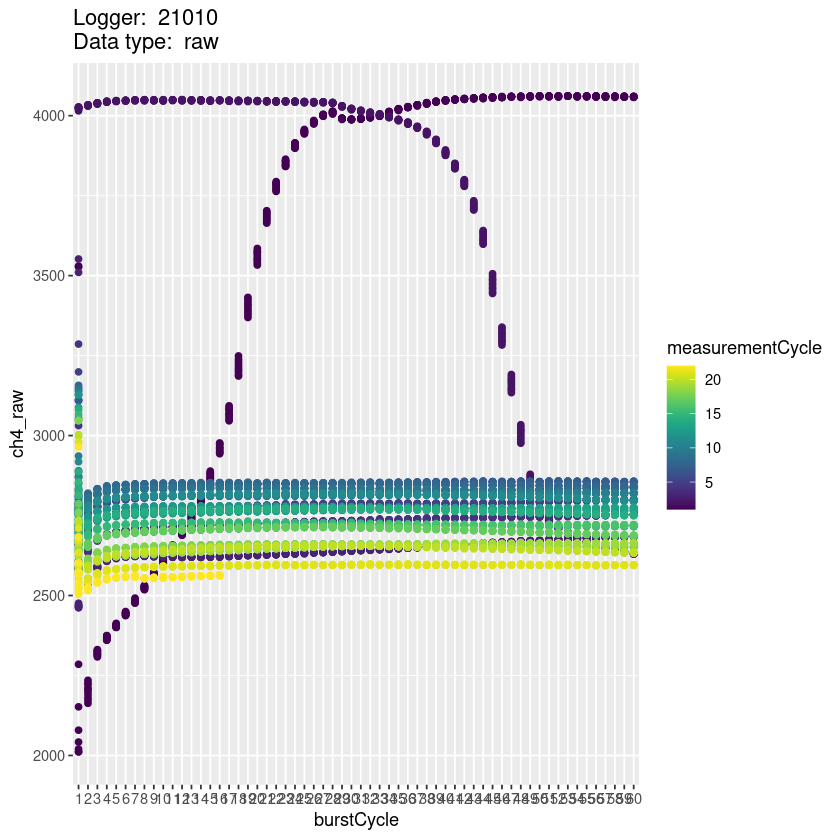

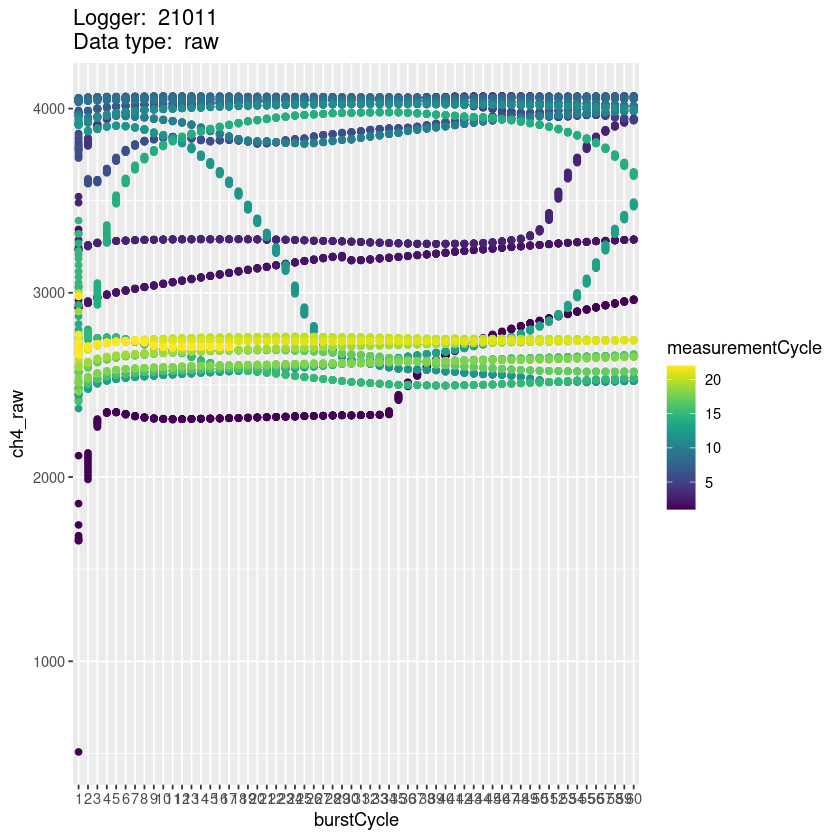

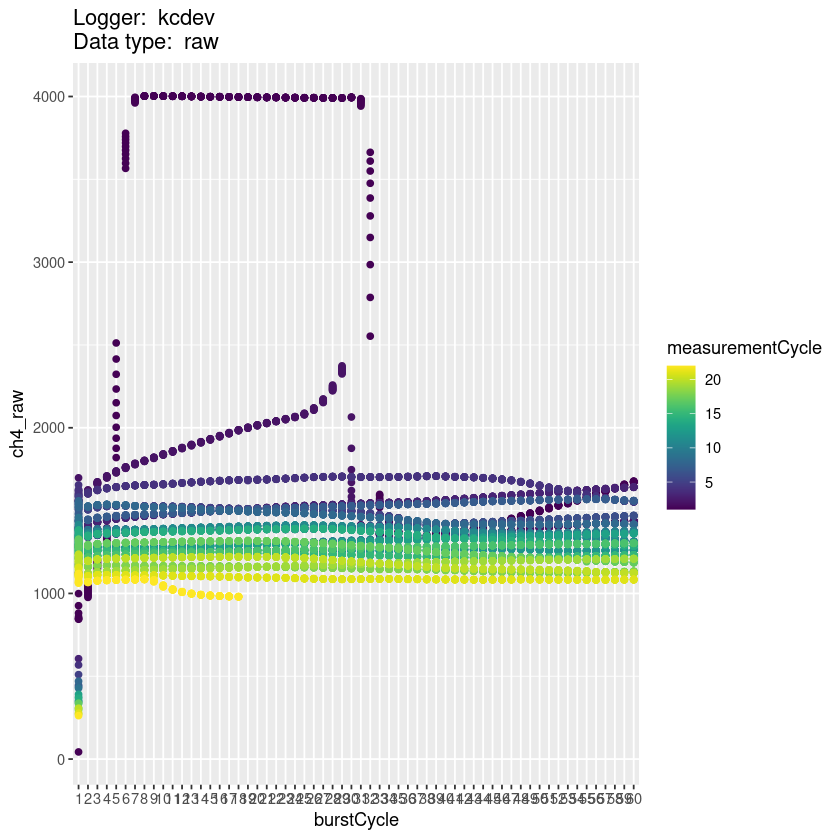

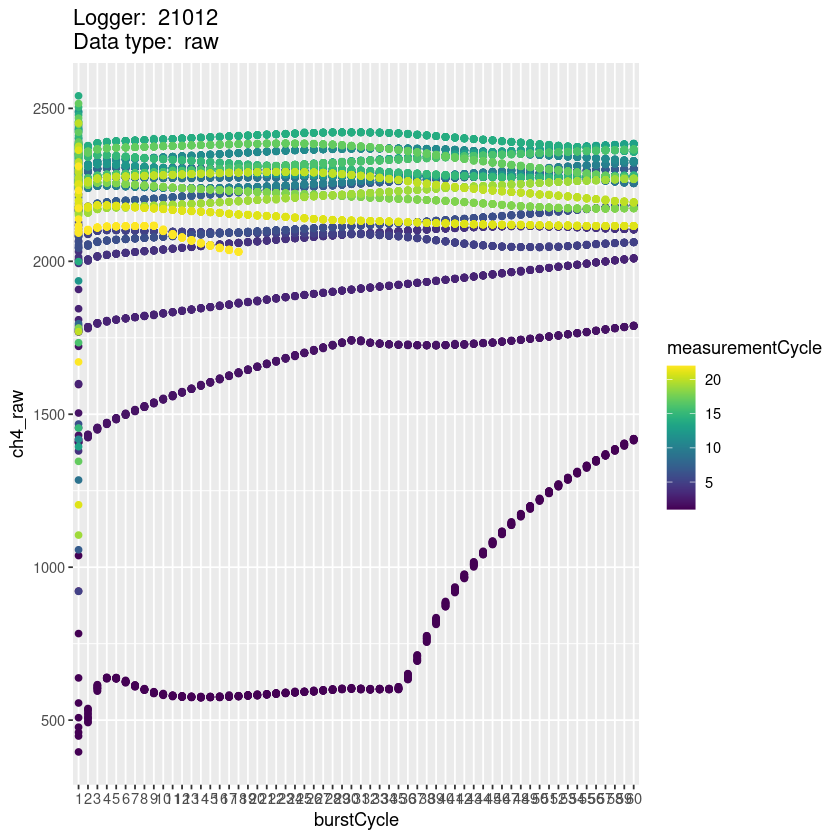

$`21010`

$`21011`

$kcdev

$`21012`

$`21013`

$`21001`


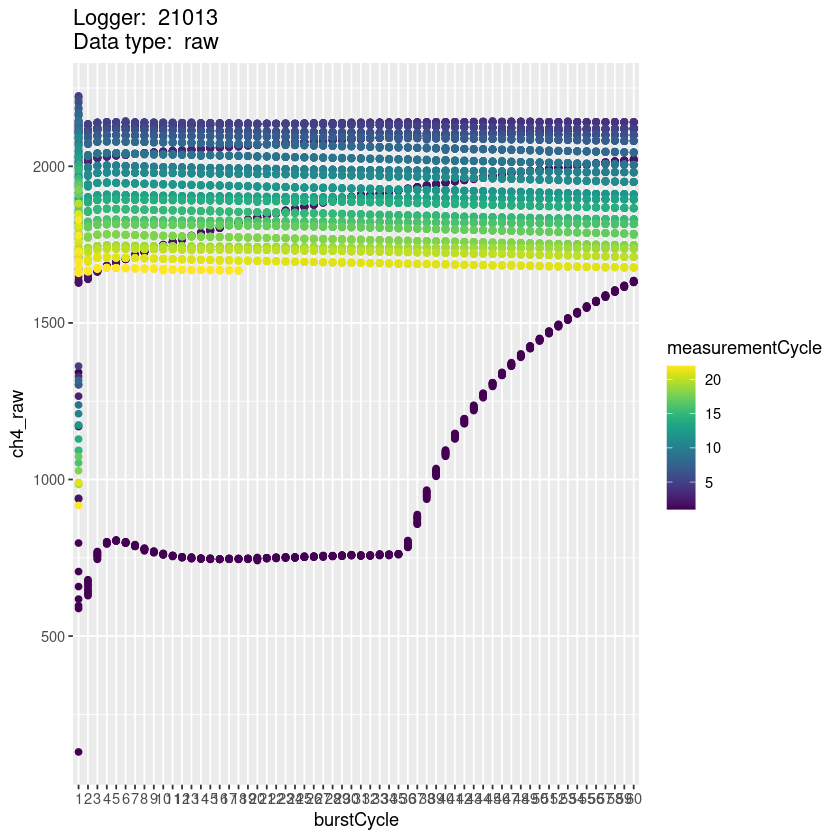

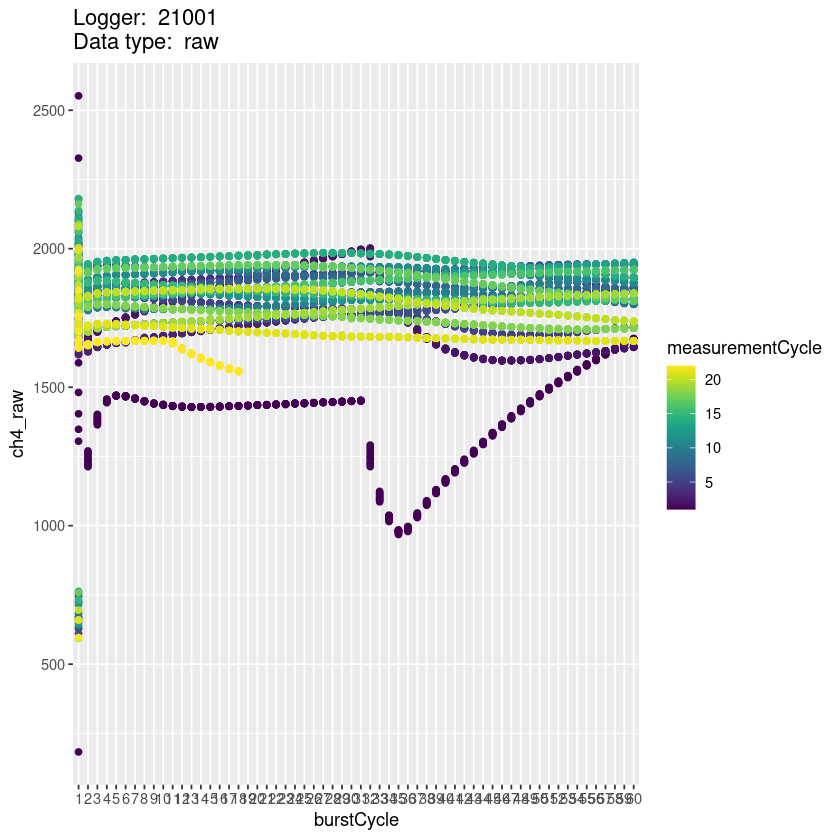

In [21]:
raw_cycleVsCH4_plots

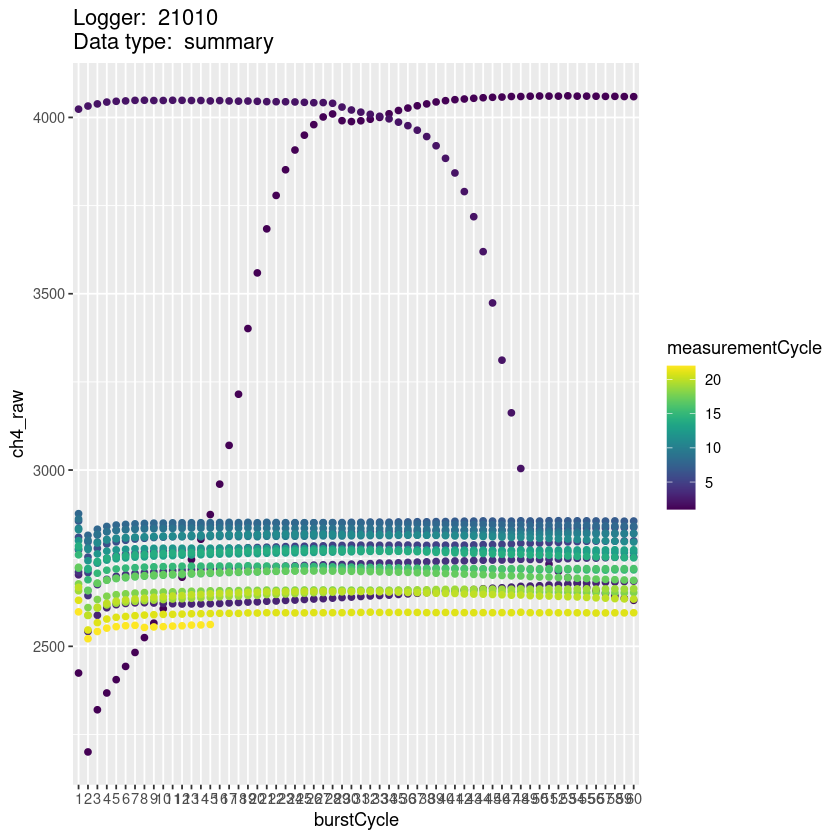

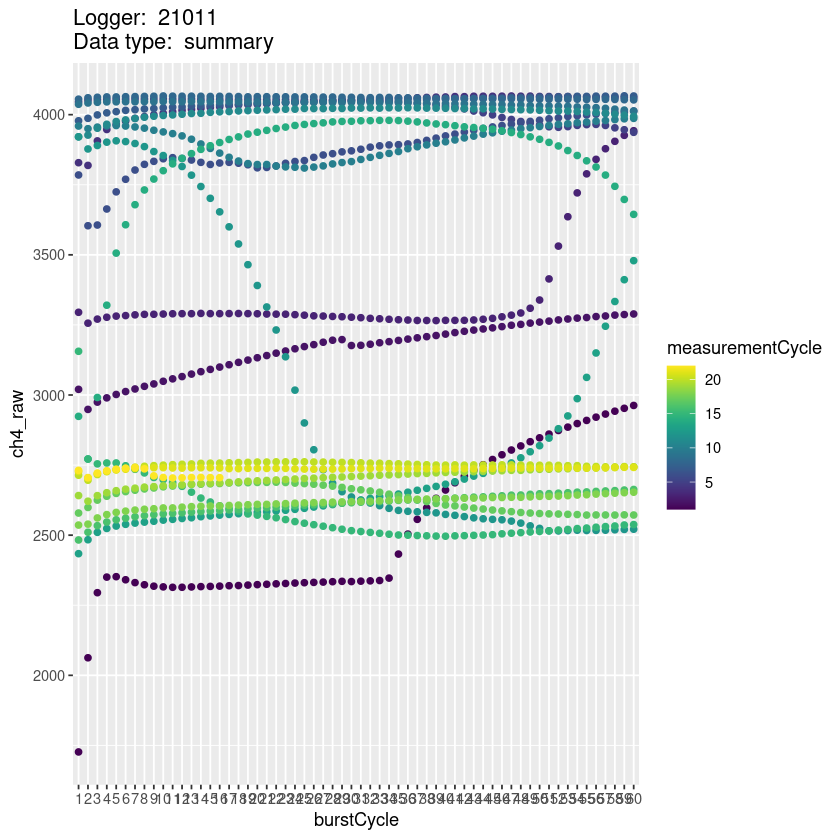

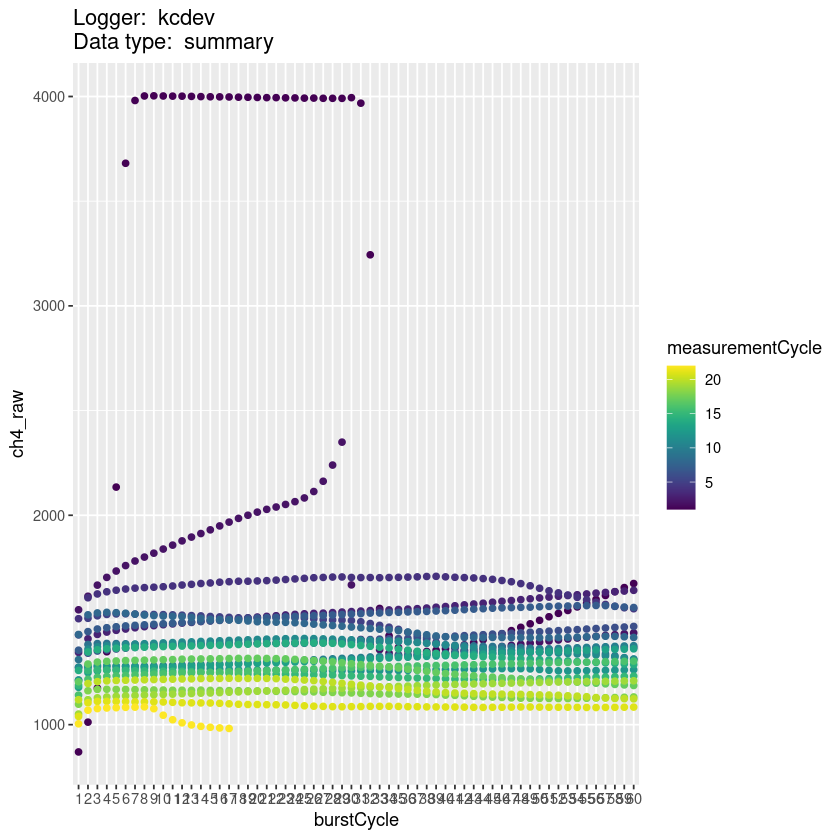

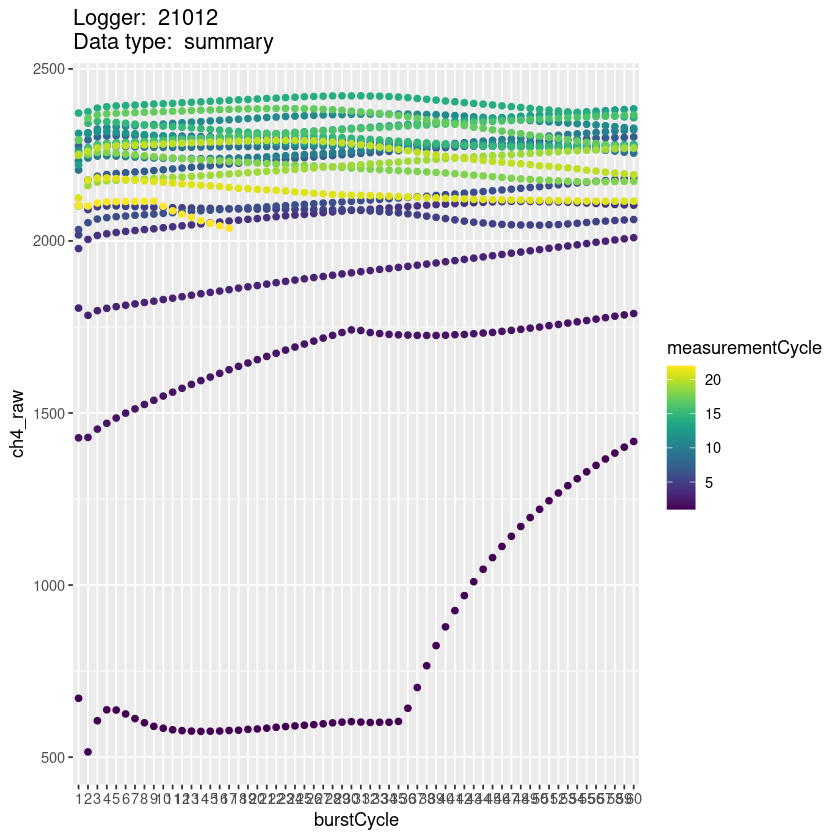

$`21010`

$`21011`

$kcdev

$`21012`

$`21013`

$`21001`


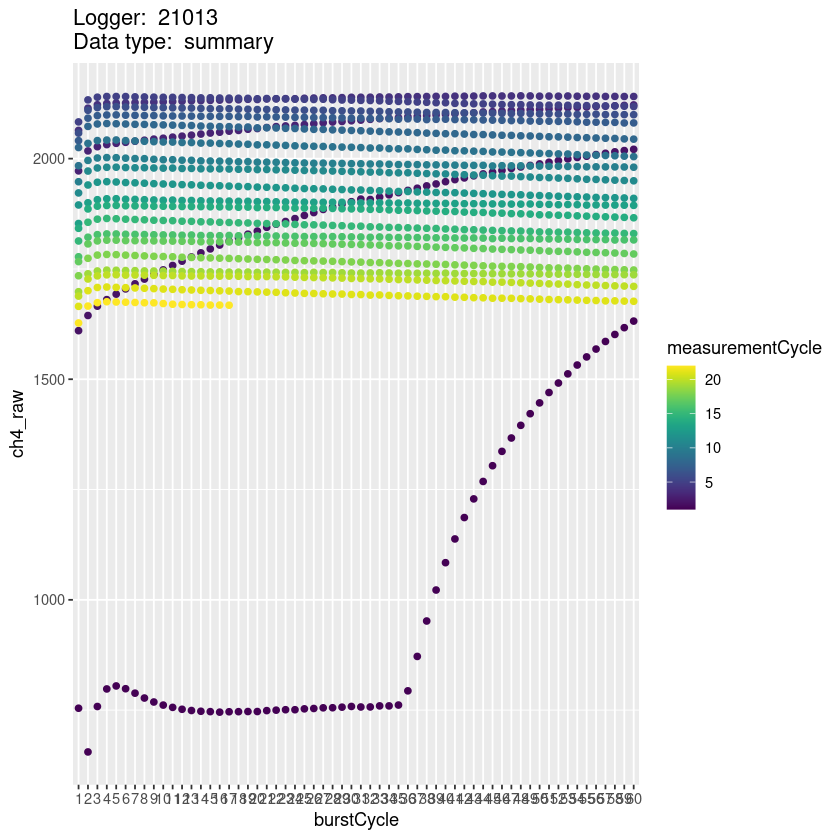

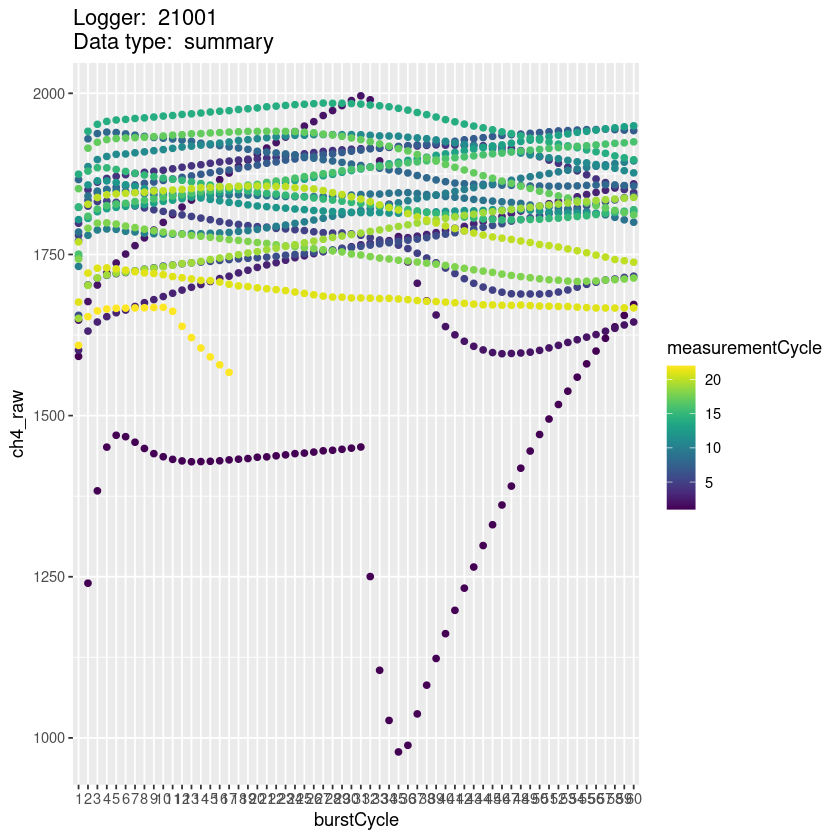

In [22]:
summary_cycleVsCH4_plots

#### Save the final processed dataframe to RDS file

In [26]:
parseSummaryDataCV<-calculateCV(processed_data, "summary")

saveDFrds(parseSummaryDataCV)
saveDFcsv(parseSummaryDataCV)

[1] "~/Desktop/data/Methane Calibration/concentration_tests/20230309_1000ppm_/RRIV_output/parseSummaryDataCV.rds"
[1] "~/Desktop/data/Methane Calibration/concentration_tests/20230309_1000ppm_/RRIV_output/parseSummaryDataCV.csv"


## calculate the mean cv of each burst and save it

In [27]:
meanCVburst<-mean_cv_burst(parseSummaryDataCV, 20)

saveDFrds(meanCVburst)
saveDFcsv(meanCVburst)

[1] "~/Desktop/data/Methane Calibration/concentration_tests/20230309_1000ppm_/RRIV_output/meanCVburst.rds"
[1] "~/Desktop/data/Methane Calibration/concentration_tests/20230309_1000ppm_/RRIV_output/meanCVburst.csv"


### Print results

In [28]:
for(i in 1:length(loggerList)){
    print(loggerList[i])
    print(subset(meanCVburst, logger==loggerList[i]))
}

[1] 21010
Levels: 21001 21010 21011 21012 21013 kcdev
   measurementCycle roll_cv.mean_na logger         deployed_at
1                 1    0.0075683684  21010 2023-03-09 17:39:25
2                 2    0.0136269958  21010 2023-03-09 17:39:25
3                 3    0.0007115559  21010 2023-03-09 17:39:25
4                 4    0.0003663131  21010 2023-03-09 17:39:25
5                 5    0.0002690883  21010 2023-03-09 17:39:25
6                 6    0.0002466235  21010 2023-03-09 17:39:25
7                 7    0.0001637672  21010 2023-03-09 17:39:25
8                 8    0.0001621938  21010 2023-03-09 17:39:25
9                 9    0.0001994295  21010 2023-03-09 17:39:25
10               10    0.0001255045  21010 2023-03-09 17:39:25
11               11    0.0002755562  21010 2023-03-09 17:39:25
12               12    0.0001738305  21010 2023-03-09 17:39:25
13               13    0.0001685236  21010 2023-03-09 17:39:25
14               14    0.0002772777  21010 2023-03-09 17:39:25
1

### Use this ^ data to decide a CV limit indicating when sensor has been sufficiently warmed
### Function to go through each logger and each measurement cycle and save the first instance where CV limit has been reached to an output dataframe

In [31]:
# first instance of CV lower than 0.01 for each measurementCycle indicates a good reading
# readings before that are not warmed up, readings after that are good but consume too much power
# Ideally we want 1 value (1 summary line and/or 10 raw lines from burst) per measurement cycle

# for each logger, for each measurement cycle, save 1 line to new dataframe
manualCVlimit<-function(parseSummaryDataCV, manualCV, ll=loggerList, lc=loggerCount){
    # TODO: first row is populated with NAs
    outputDF<-data.frame(matrix(ncol=length(parseSummaryDataCV), nrow=0))
    colnames(outputDF)<-names(parseSummaryDataCV)

    for(i in 1:lc){
        oneLogger<-subset(parseSummaryDataCV, logger==ll[i])

        measurementCycles<-length(unique(oneLogger$measurementCycle))

        for(j in 1:measurementCycles){
            oneCycle<-subset(oneLogger, measurementCycle==j)
            
            #save the first instance where the rolling cv has reached the desired limit
            # TODO: save line with the lowest CV reached if has not reached the desired limit
            # errors not an issue currently: reporting warnings where CV not calculated or mostly NA values
            rowFound<-min(which(oneCycle$roll_cv<manualCV), na.rm=TRUE)
            if(!is.integer(rowFound)){
                print(sprintf("cv limit not reached for logger:%s measurementCycle:%d", ll[i], j))
                print(sprintf("lowest cv is: %f", min(oneCycle$roll_cv, na.rm=TRUE)))
            }else{
                outputDF<-rbind(outputDF,oneCycle[rowFound,])
            }
        }
    }
    outputDF<-process_rriv_columns(outputDF)
    # either sort the categorical factor burst cycles or change them to numeric here:
    outputDF$burstCycle<-as.numeric(outputDF$burstCycle)
    return(outputDF)
}

### Subset good data and save it to rds and csv

In [32]:
summary_manualCVdata<-manualCVlimit(parseSummaryDataCV, 0.01)
# outputDF$measurementCycle<-as.numeric(outputDF$measurementCycle)

saveDFrds(summary_manualCVdata)
saveDFcsv(summary_manualCVdata)

#TODO: mean burstCycle(how many minutes it took to warm up) & standard error, and actual cv value

[1] "~/Desktop/data/Methane Calibration/concentration_tests/20230309_1000ppm_/RRIV_output/summary_manualCVdata.rds"
[1] "~/Desktop/data/Methane Calibration/concentration_tests/20230309_1000ppm_/RRIV_output/summary_manualCVdata.csv"


In [35]:
variableDict<-getDict(parseSummaryDataCV)

variableCount<-length(variableDict)
variableKeys<-names(variableDict)

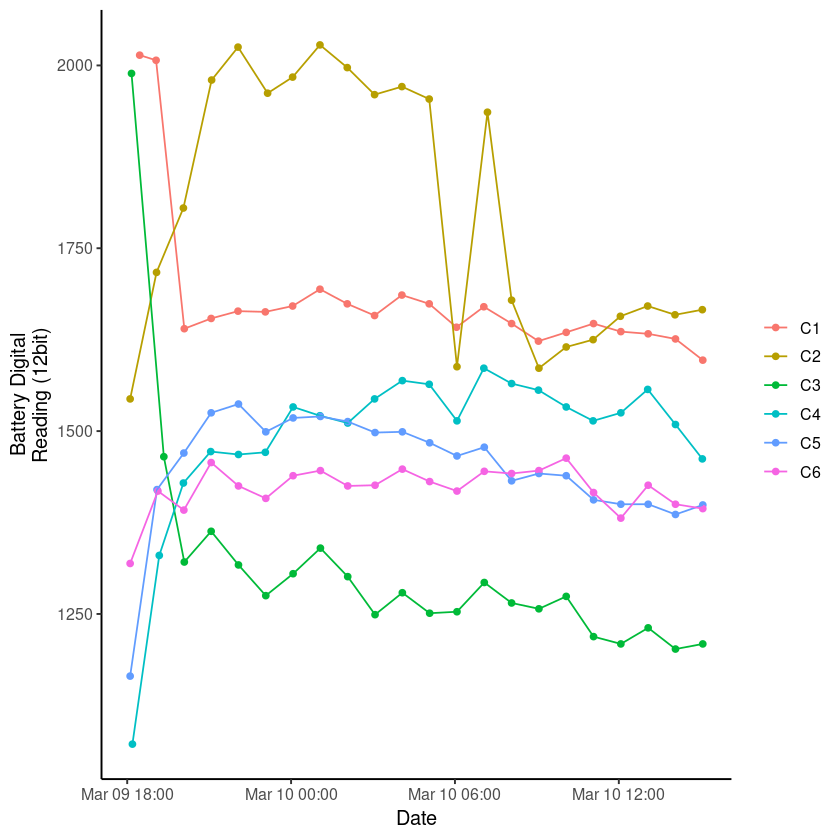

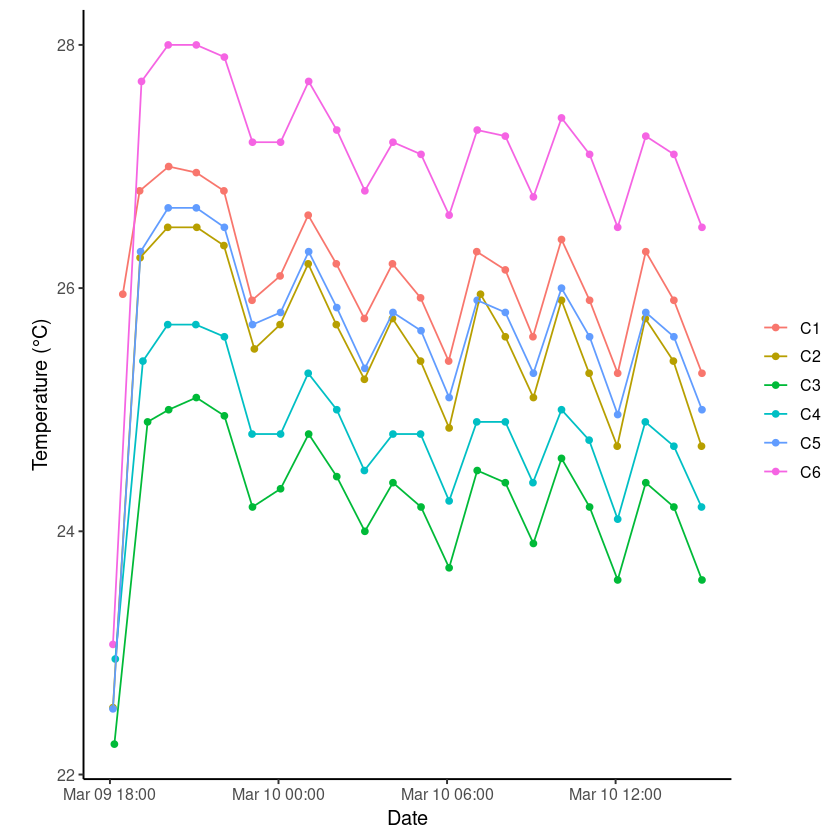

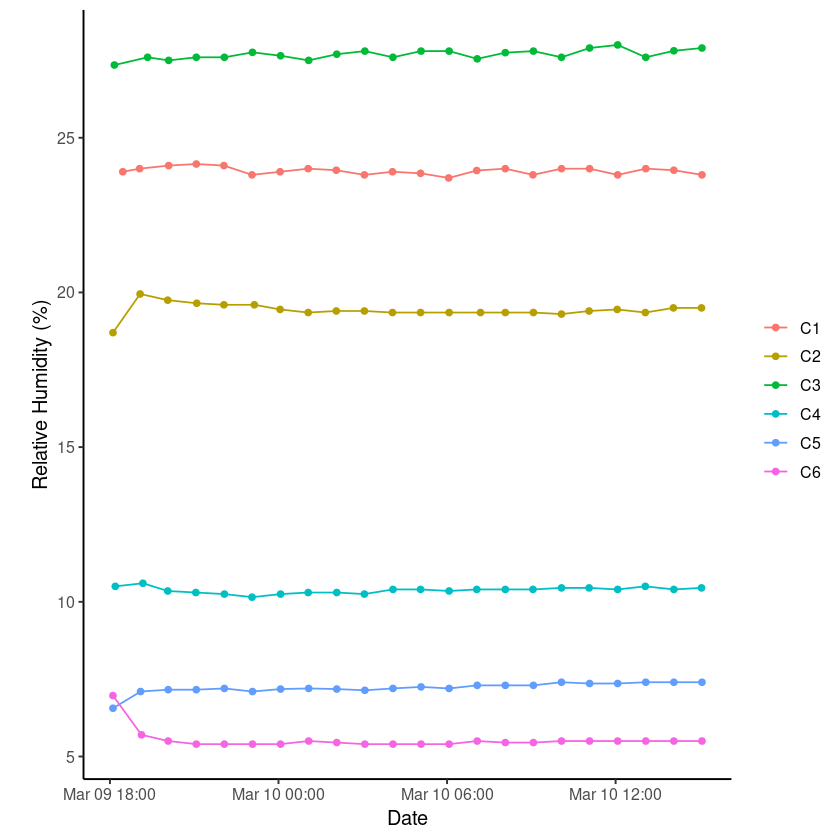

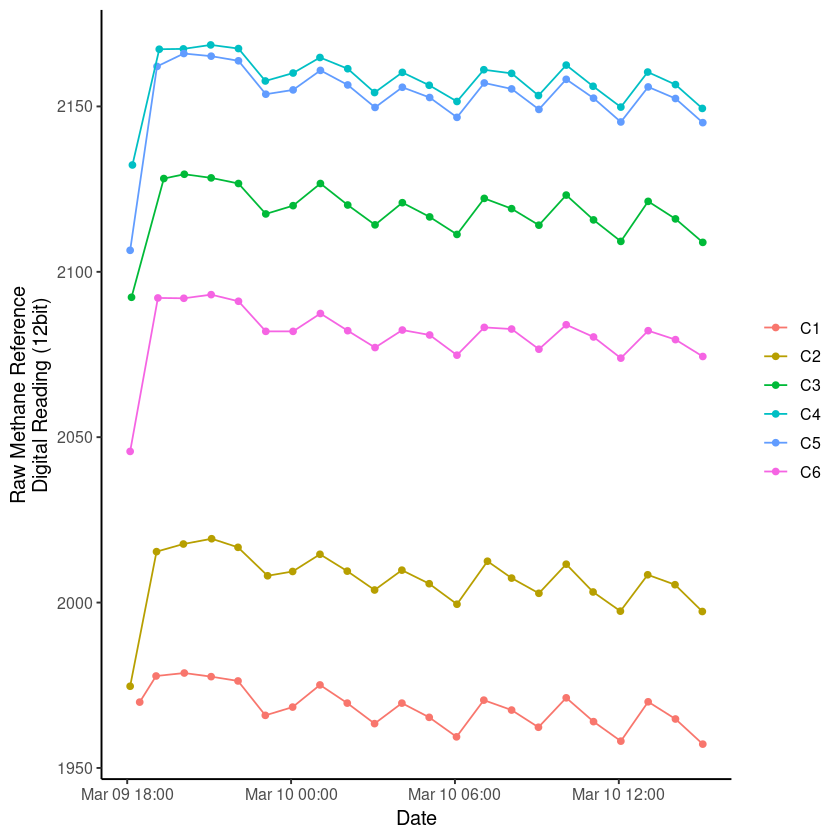

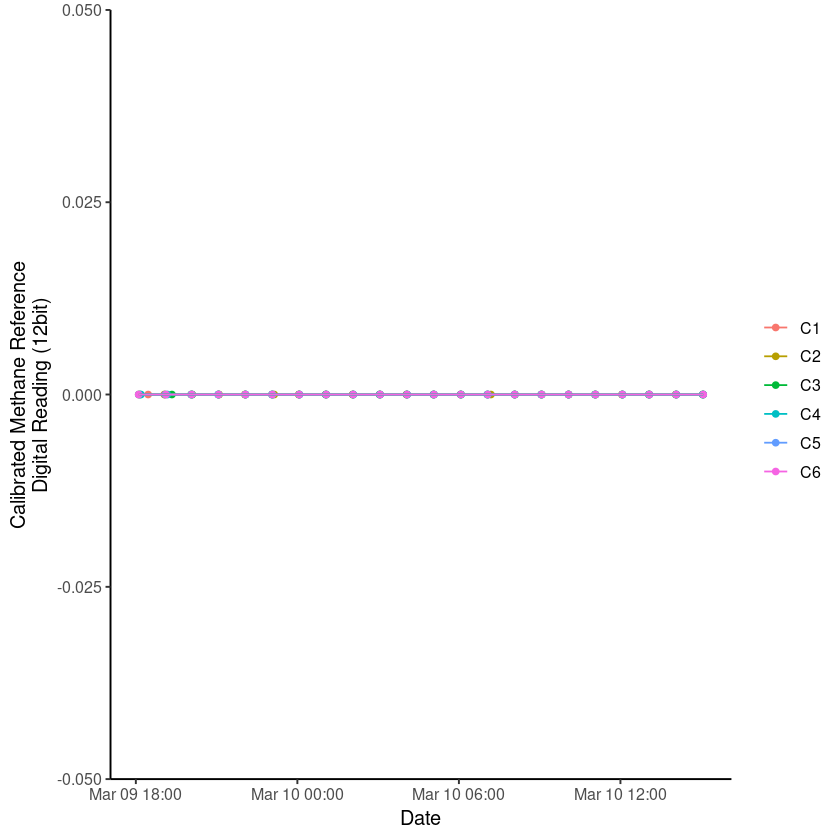

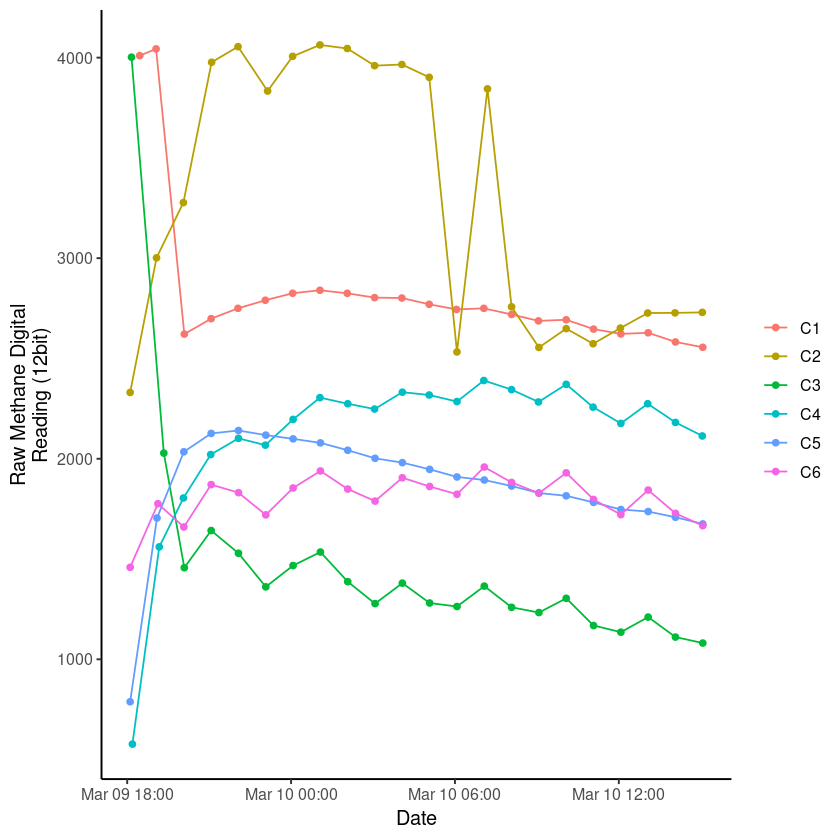

$battery.V

$dht_C

$dht_RH

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal

$roll_cv


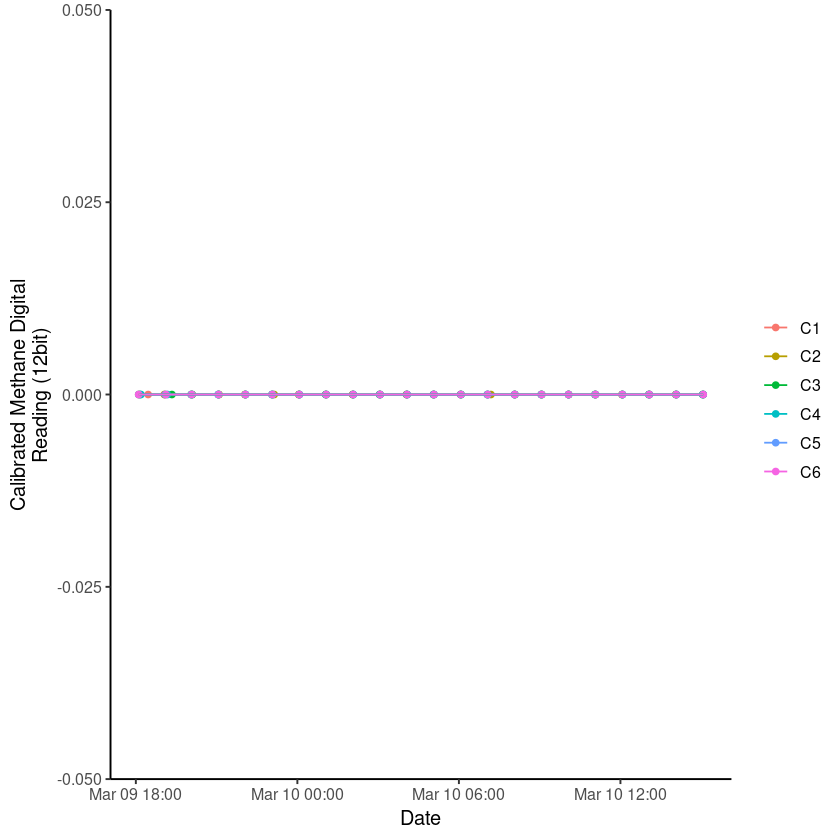

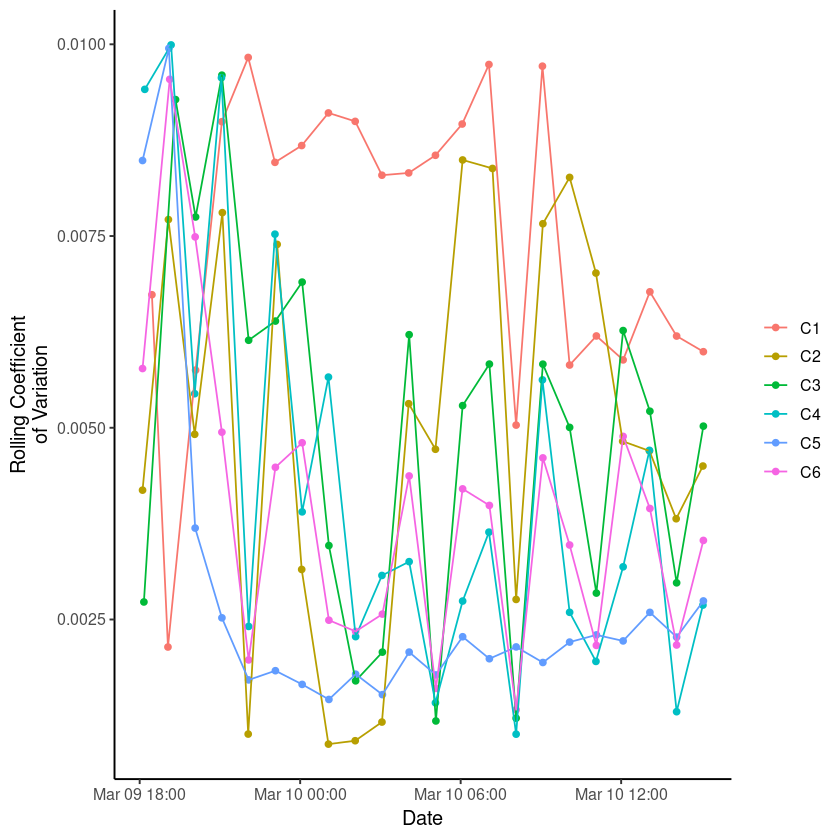

In [36]:
loggerPlots<-plot_Data_v_Time(summary_manualCVdata, "site")
loggerPlots

savePlotList(loggerPlots, "sp_manualCV_")

In [38]:
range(summary_manualCVdata$time.h)

[1] "2023-03-09 18:06:26 UTC" "2023-03-10 15:04:27 UTC"

[1] "2023-03-09 18:00:00 UTC"

[1] "2023-03-09 19:00:00 UTC"

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



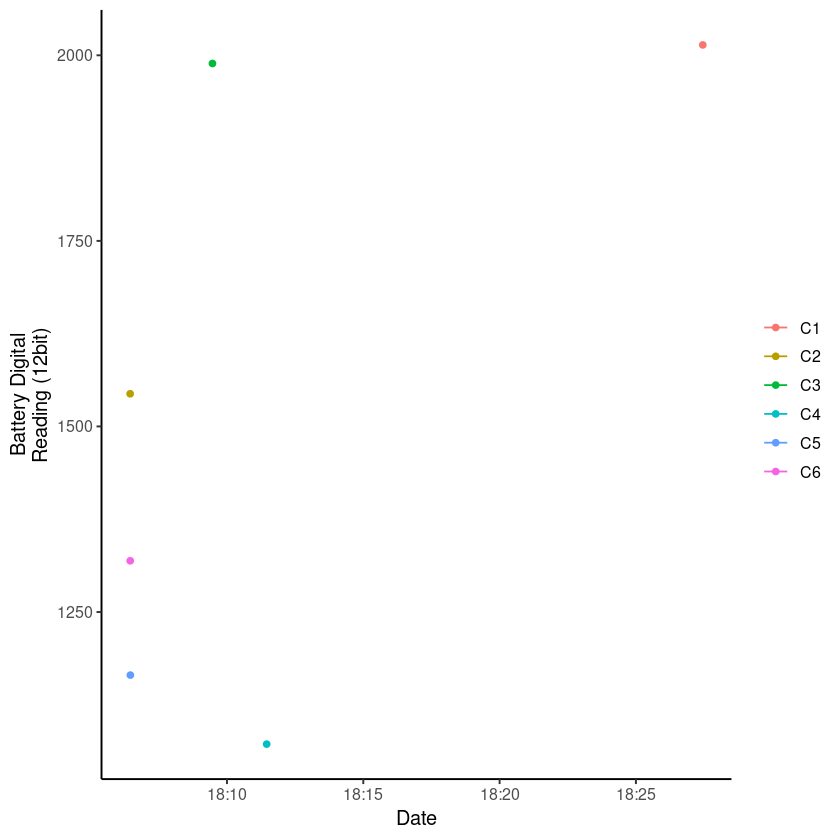

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



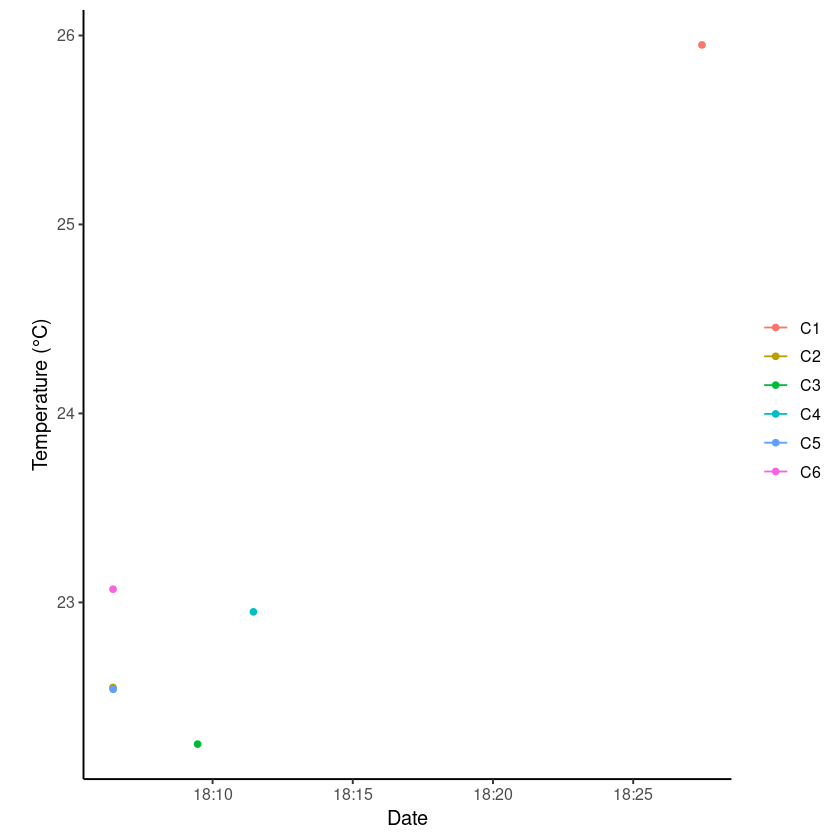

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



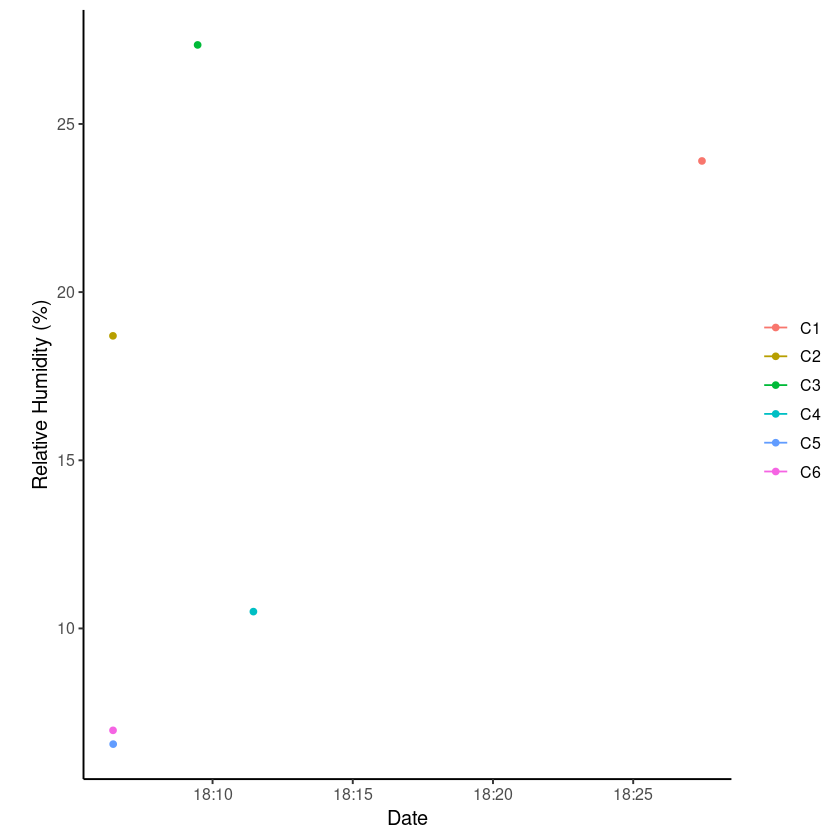

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



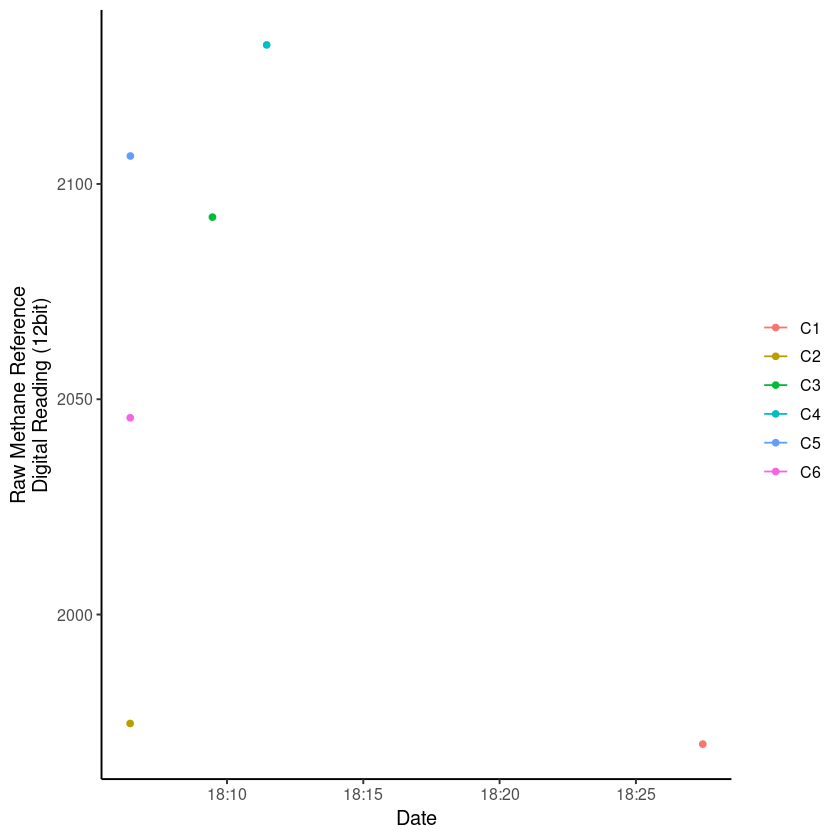

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



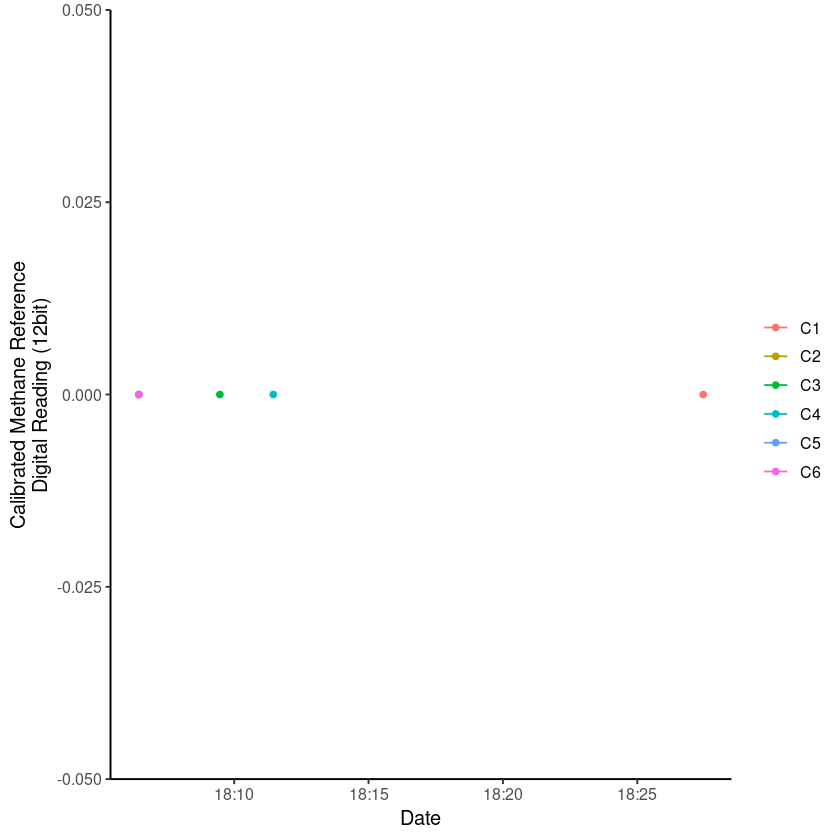

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



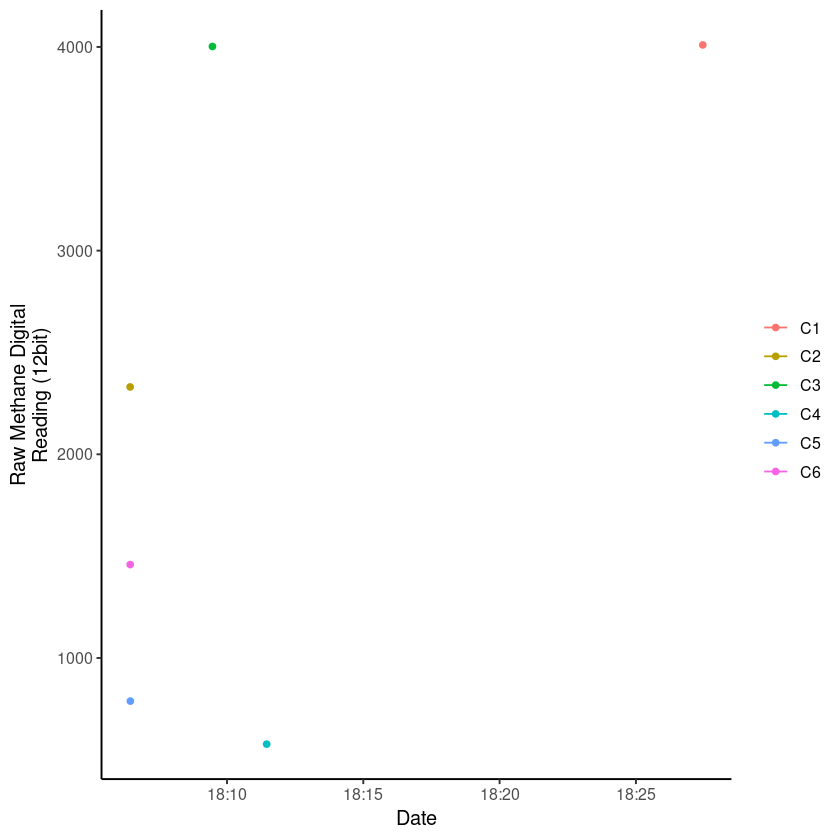

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



$battery.V

$dht_C

$dht_RH

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal

$roll_cv


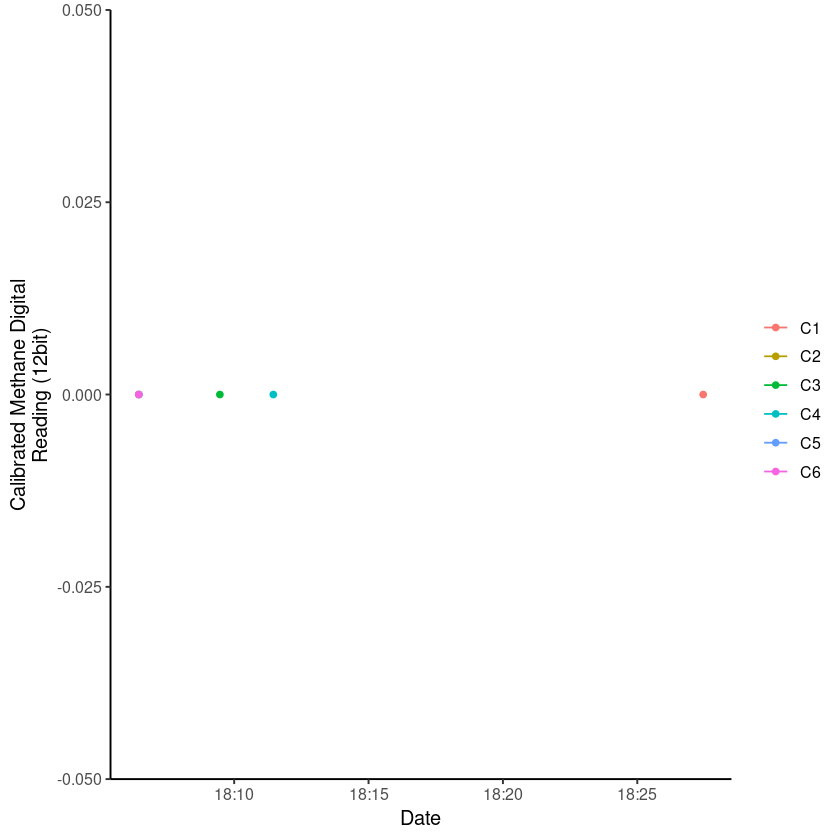

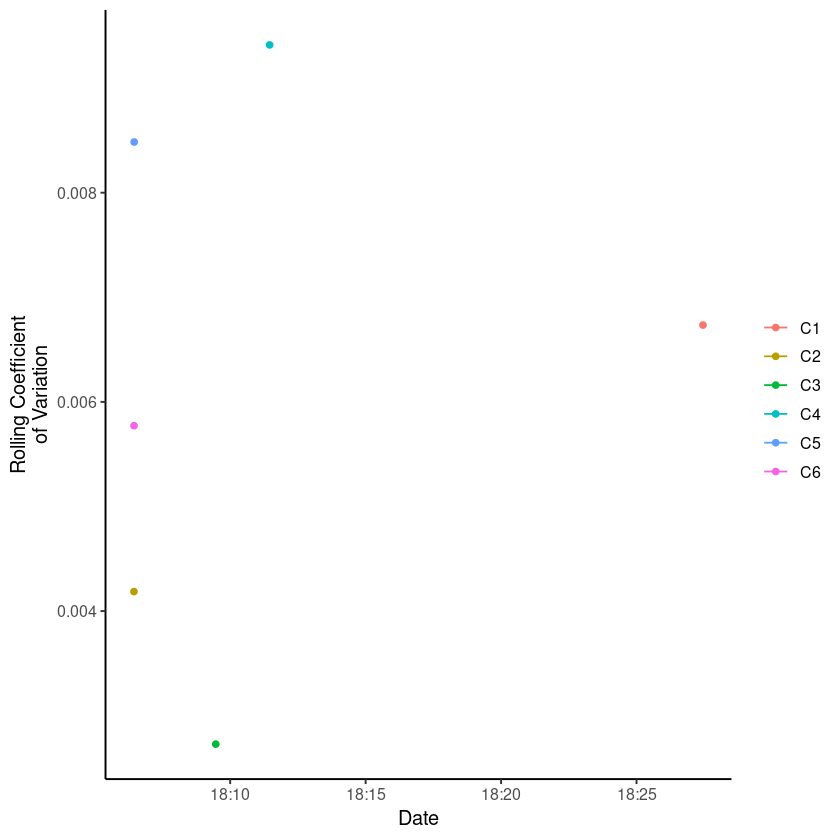

In [44]:
# startTime<-lubridate::as_datetime("2023-03-09 18:06:26 UTC")
# startTime <-round(startTime,units="hours")
# startTime
# endTime<-startTime+1*60*60
# endTime

# subset1<-summary_manualCVdata[summary_manualCVdata$time.h>startTime &
#                              summary_manualCVdata$time.h<endTime ,]


# loggerPlots<-plot_Data_v_Time(subset1, "site")
# loggerPlots

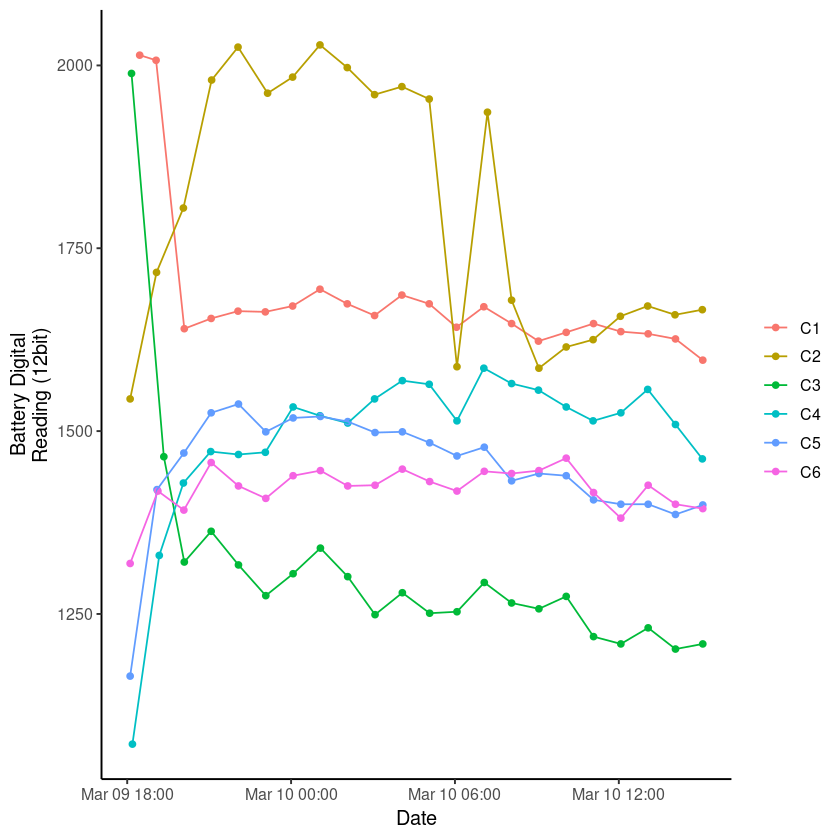

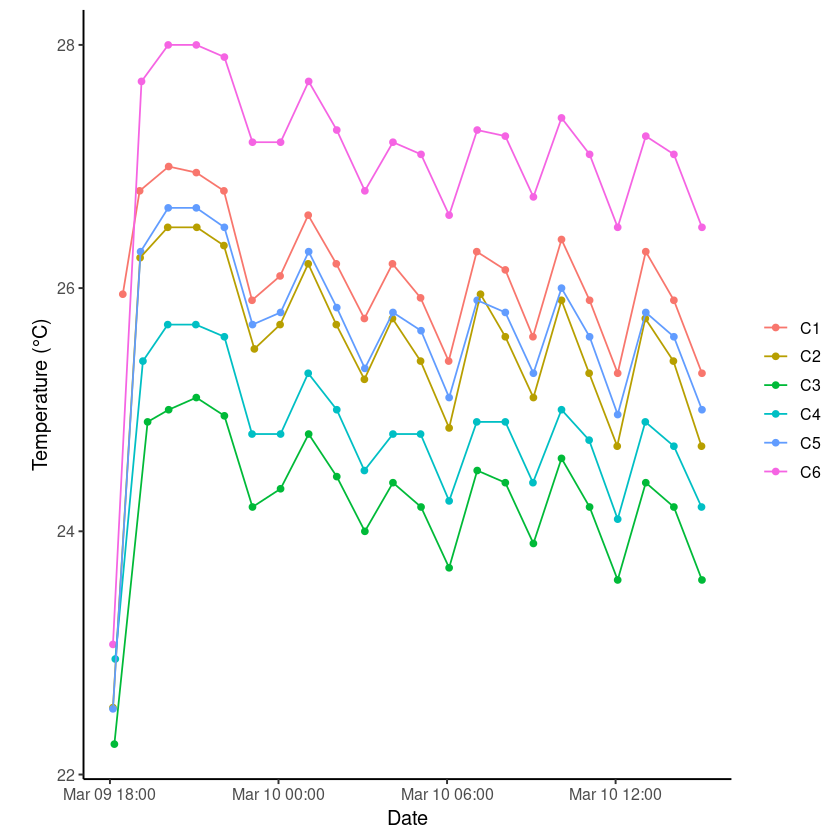

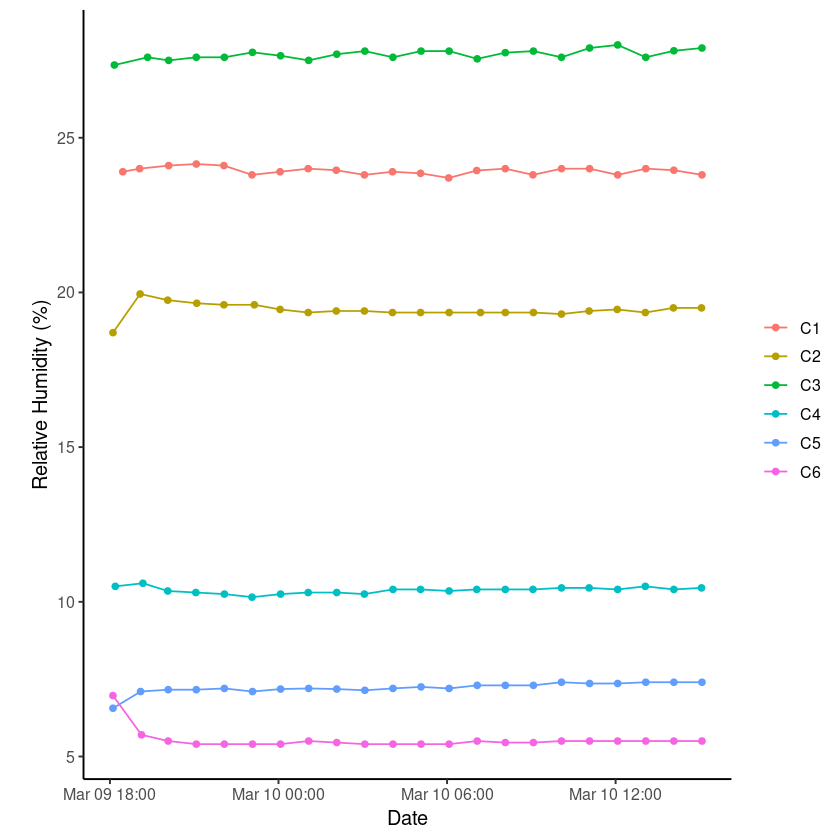

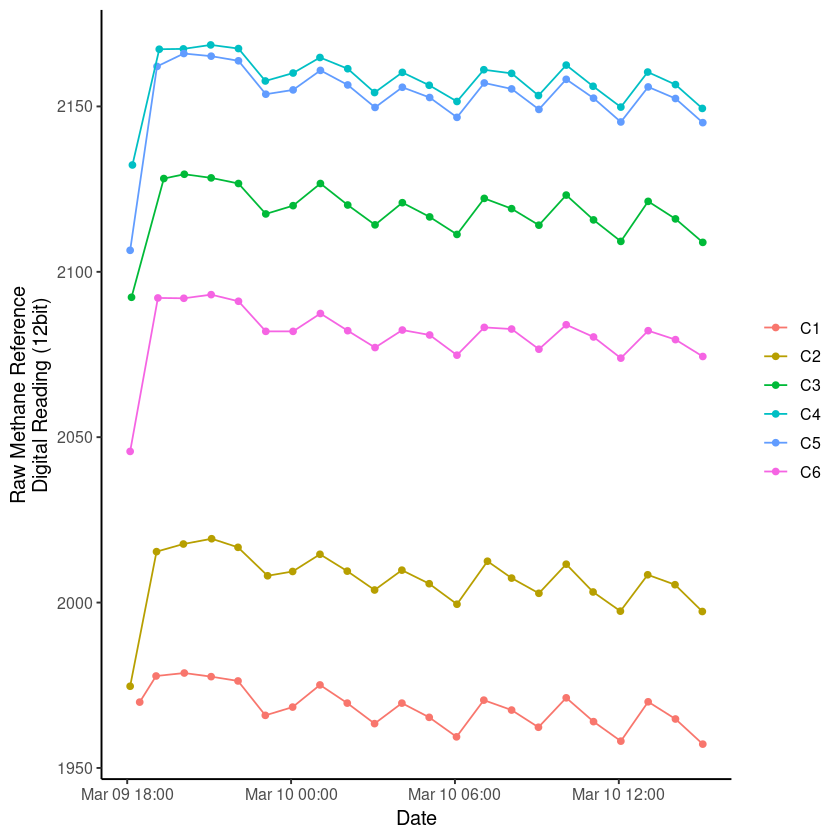

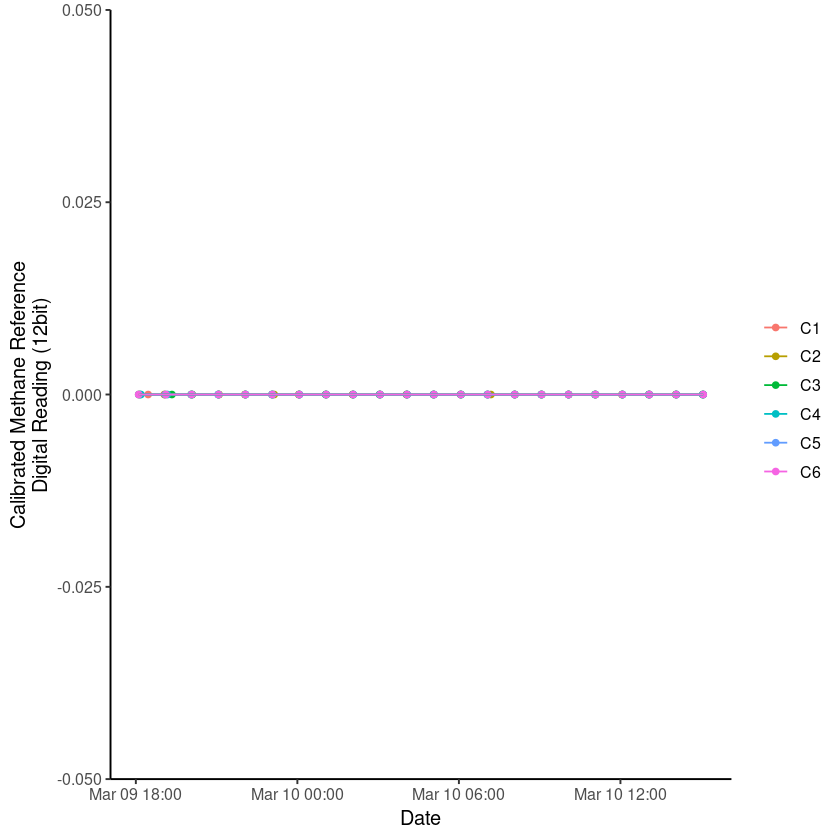

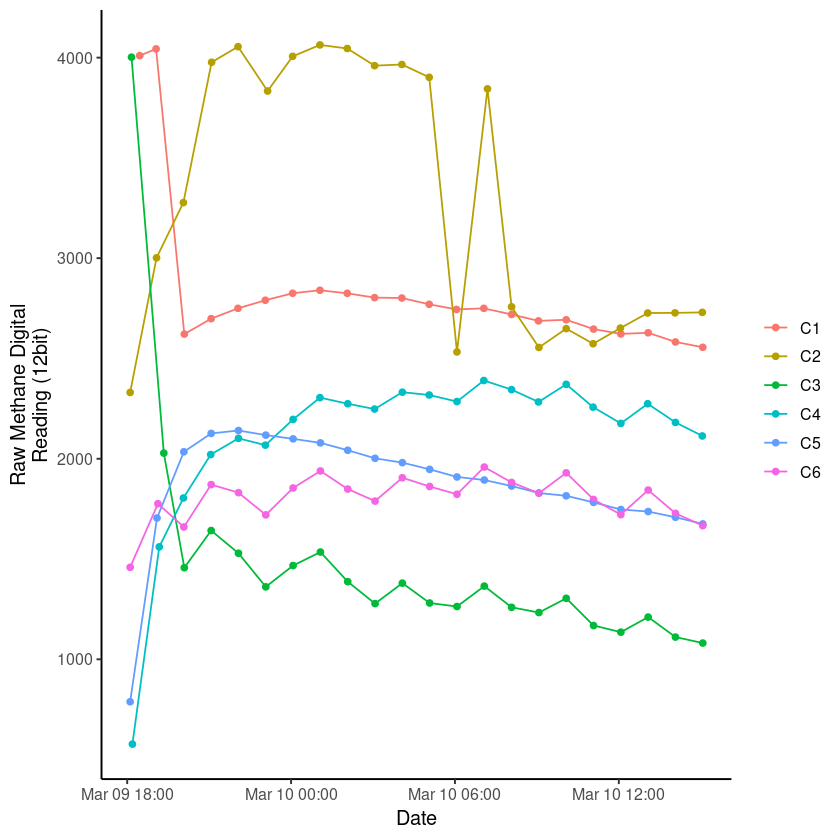

$battery.V

$dht_C

$dht_RH

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal

$roll_cv


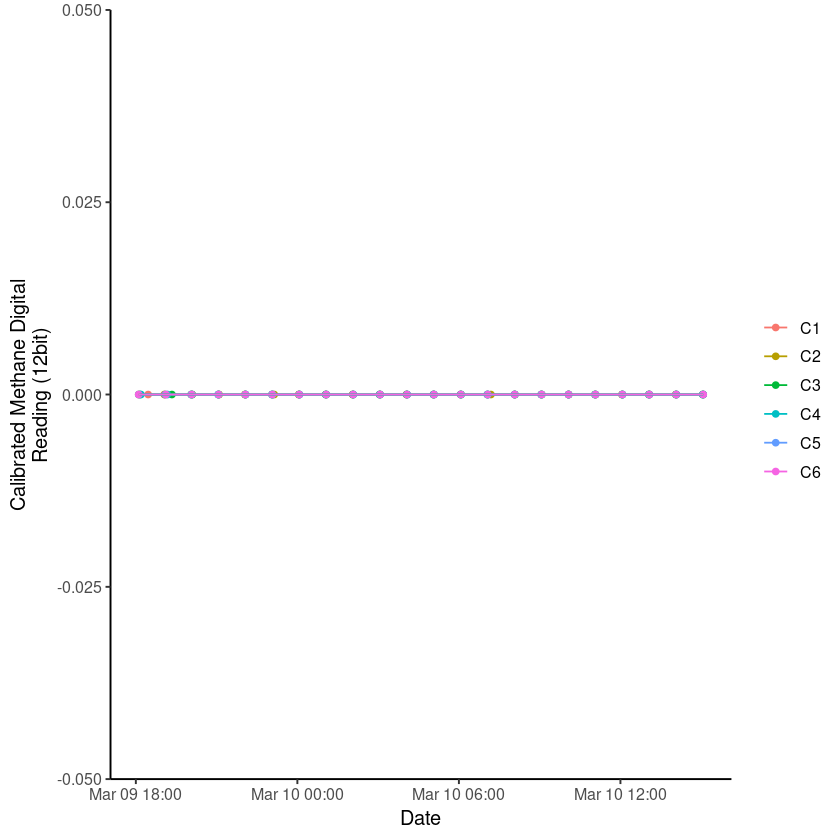

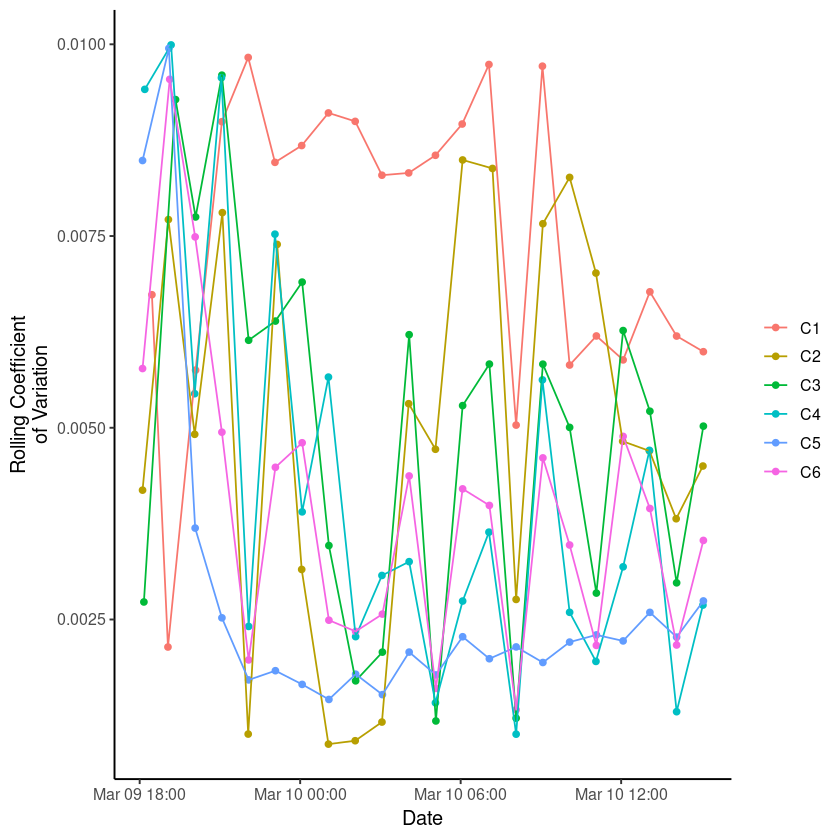

In [42]:
# startTime<-endTime
# endTime<-startTime+1*60*60
# startTime
# endTime

# subset2<-summary_manualCVdata[summary_manualCVdata$time.h>startTime &
#                              summary_manualCVdata$time.h<endTime ,]

# loggerPlots<-plot_Data_v_Time(summary_manualCVdata, "site")
# loggerPlots

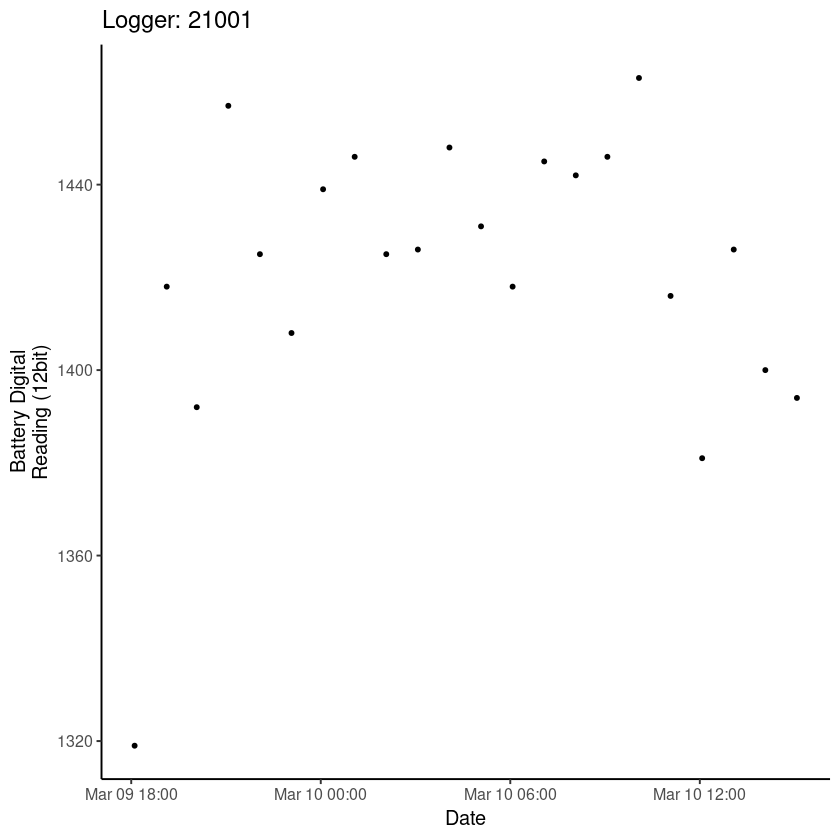

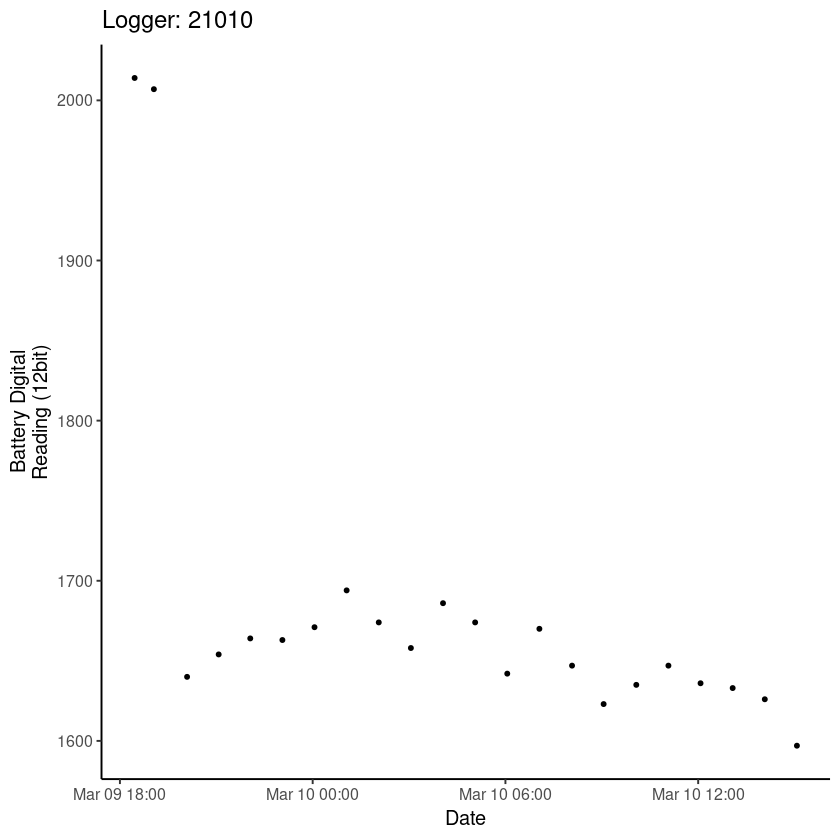

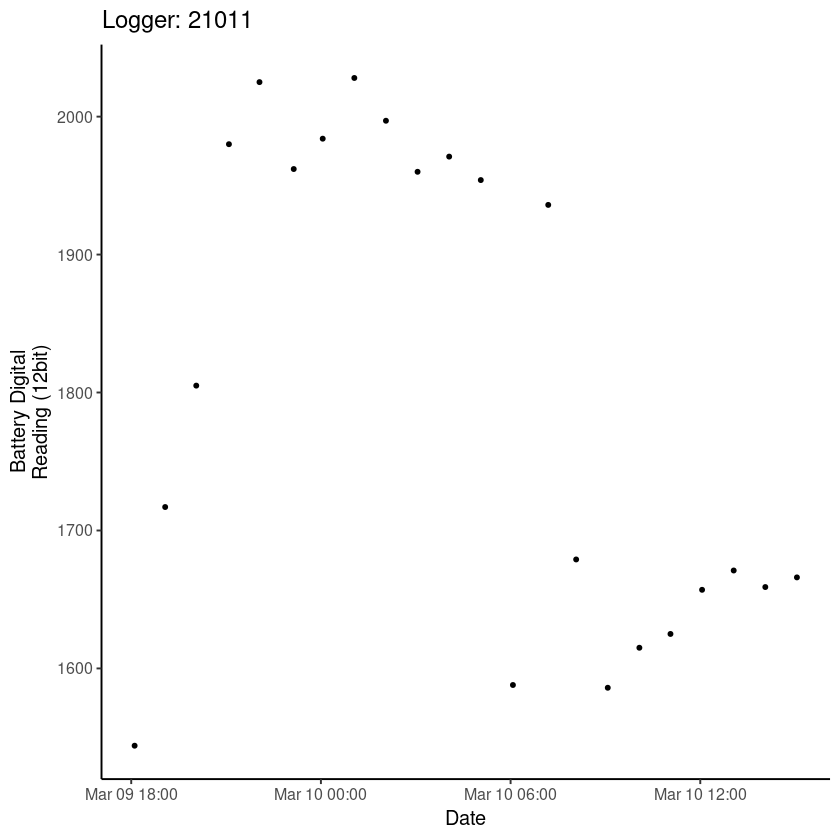

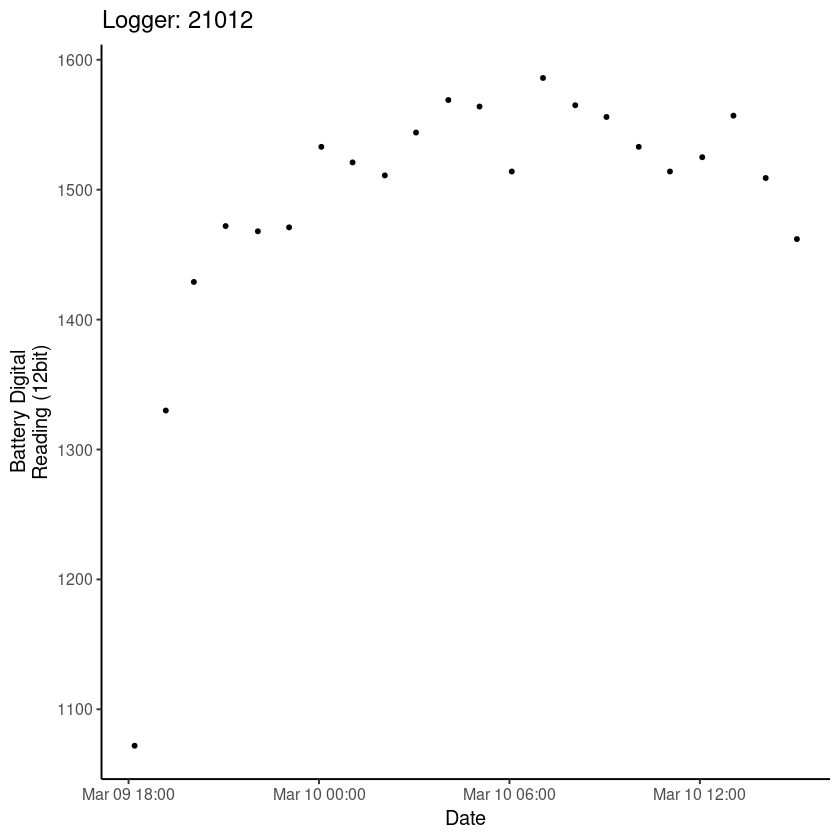

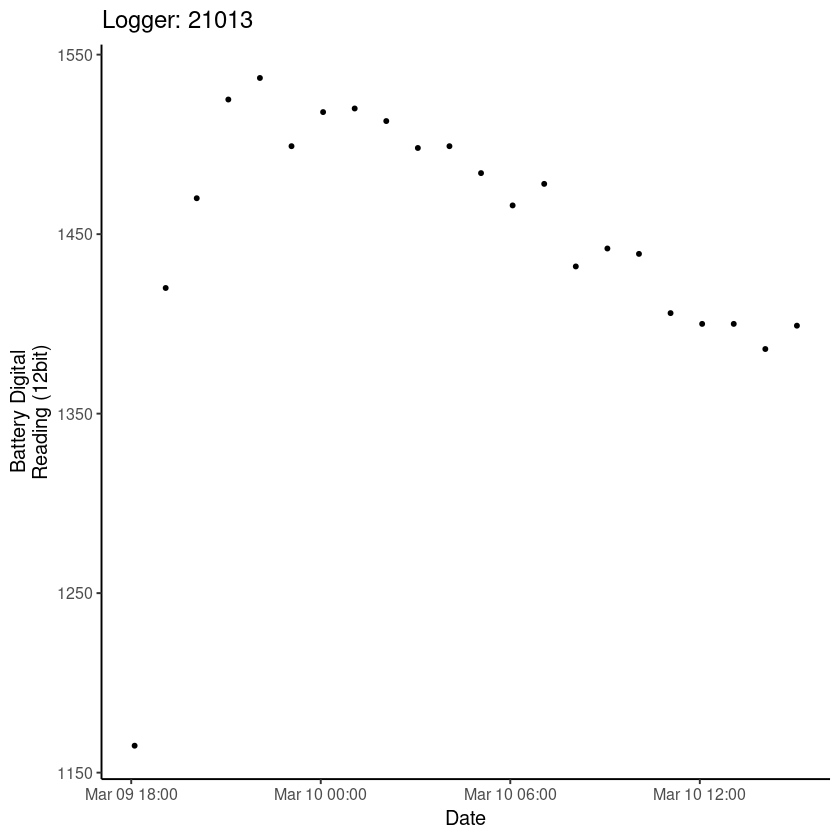

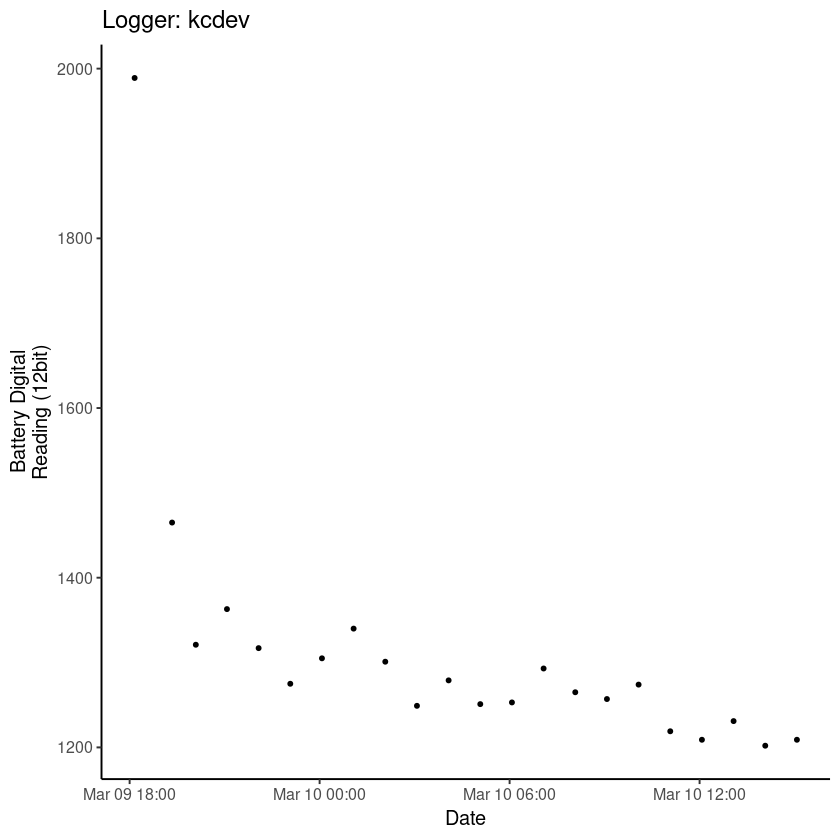

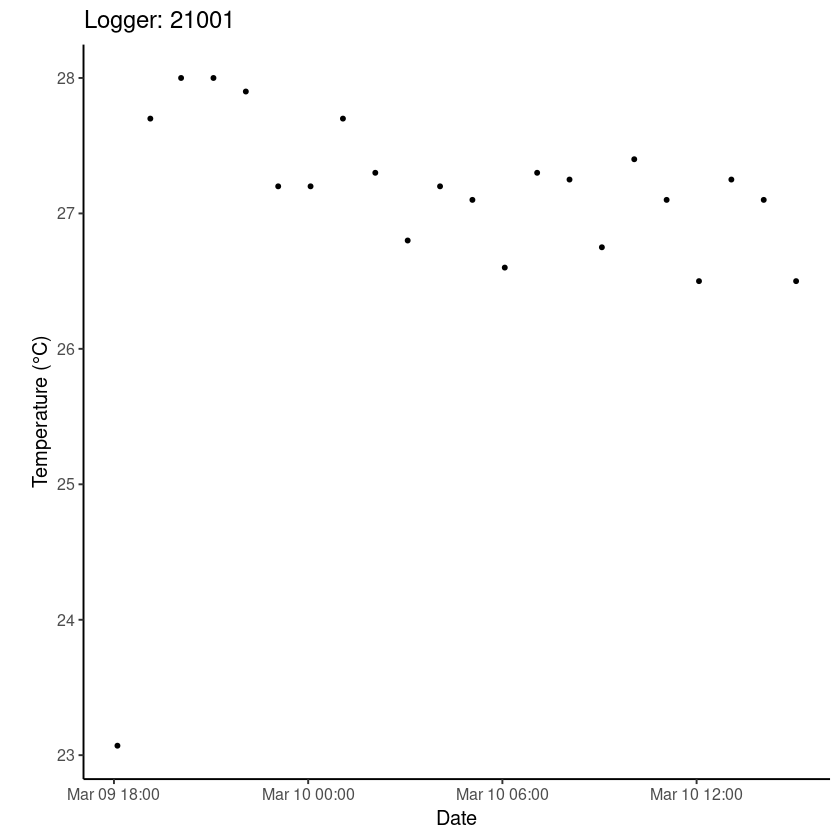

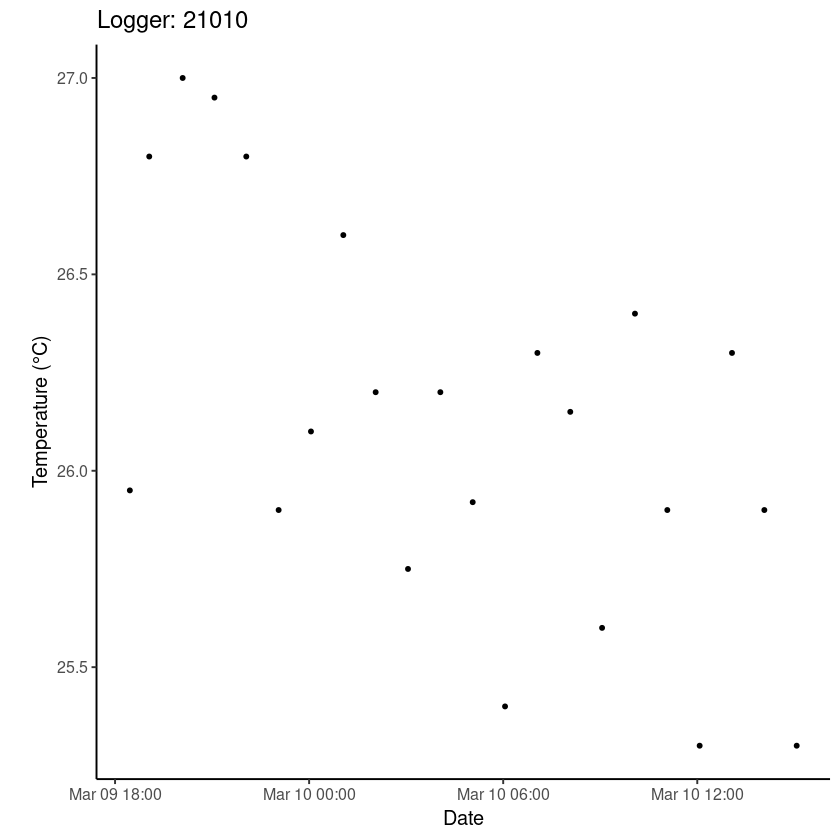

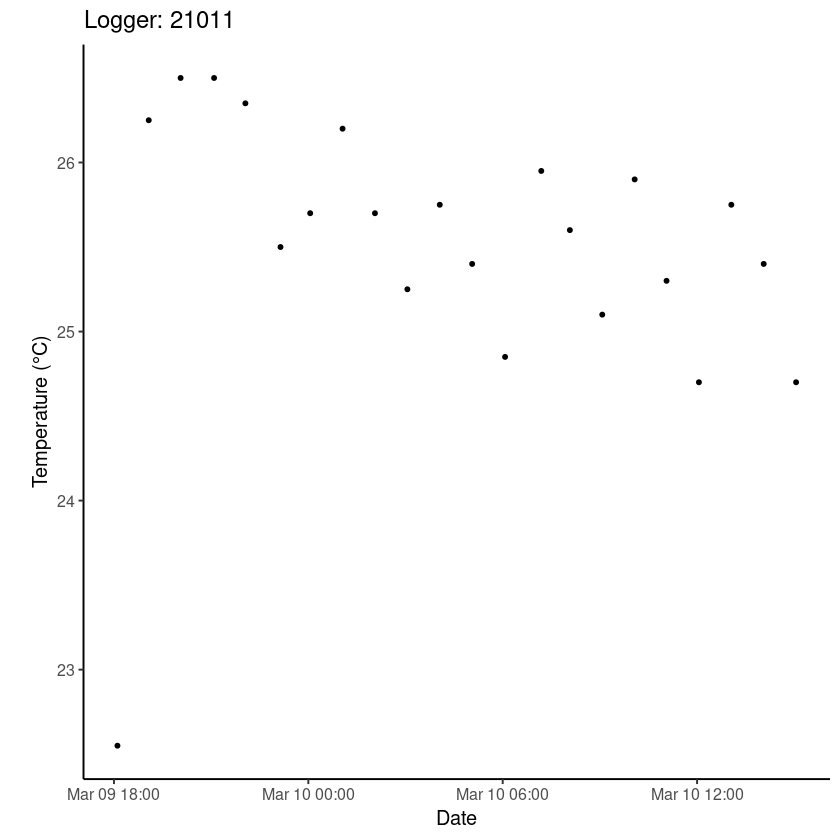

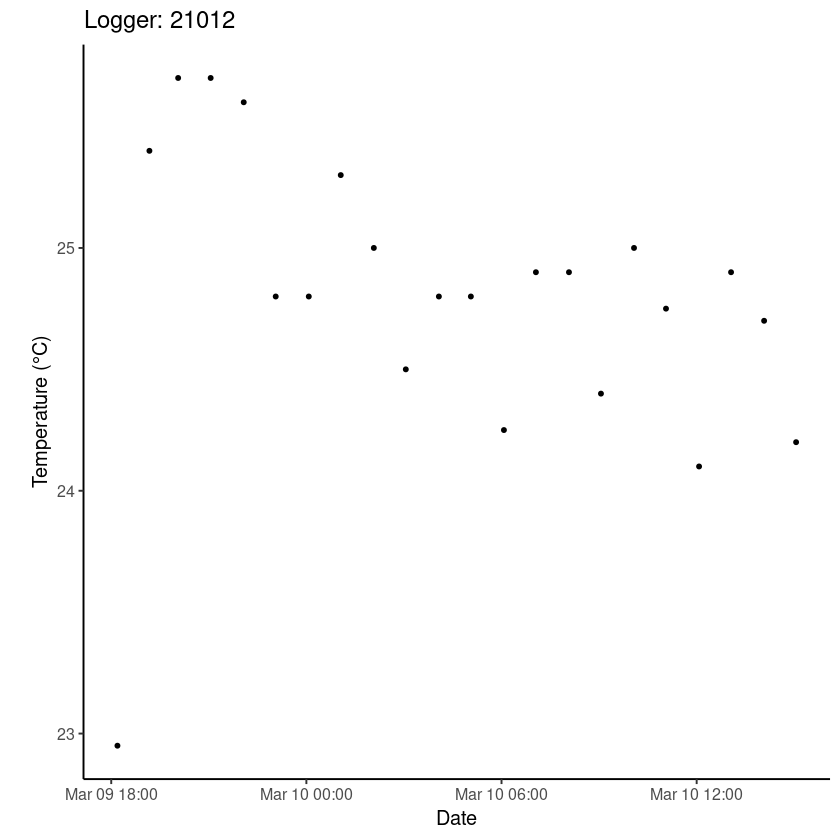

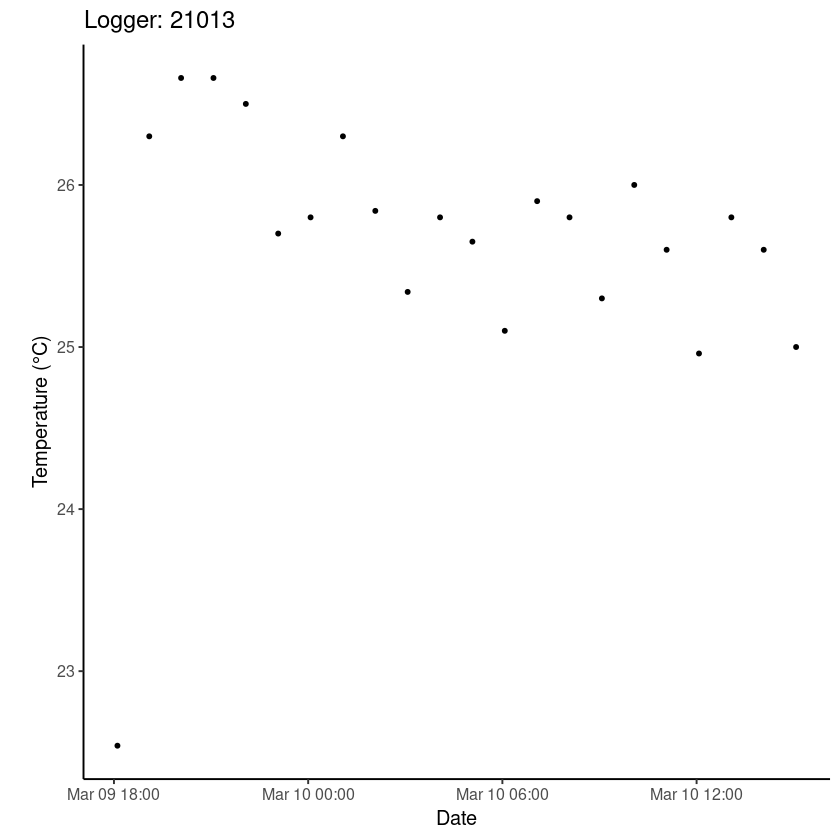

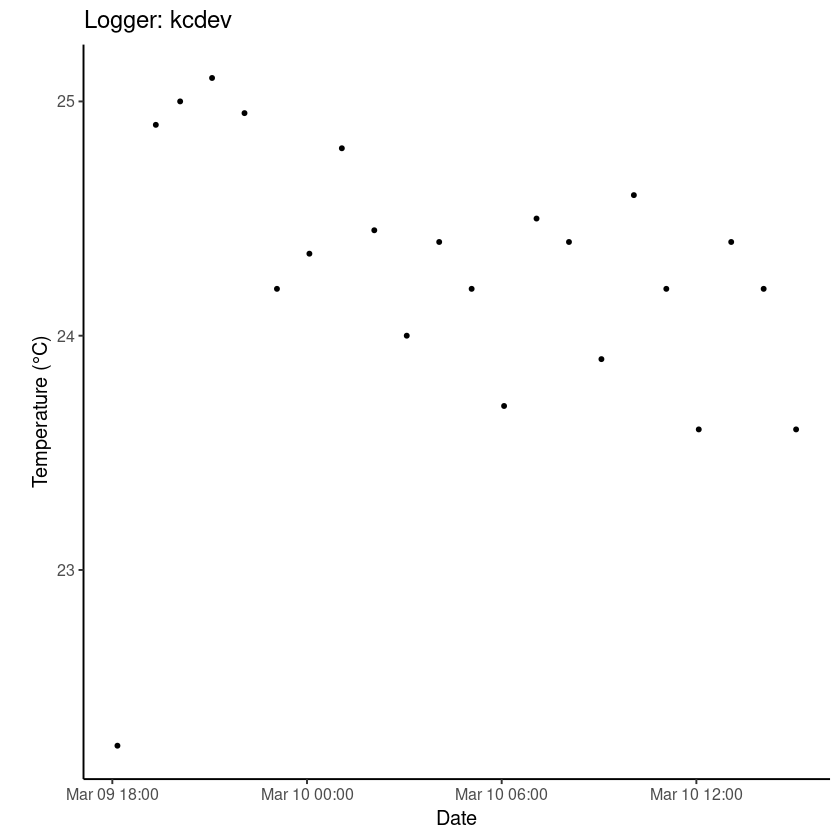

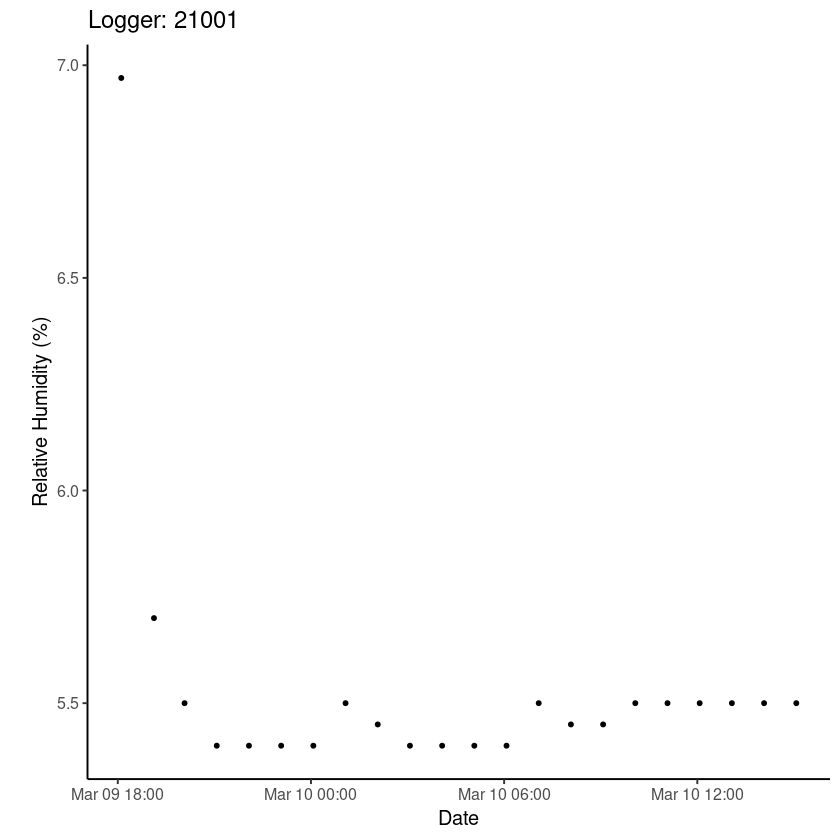

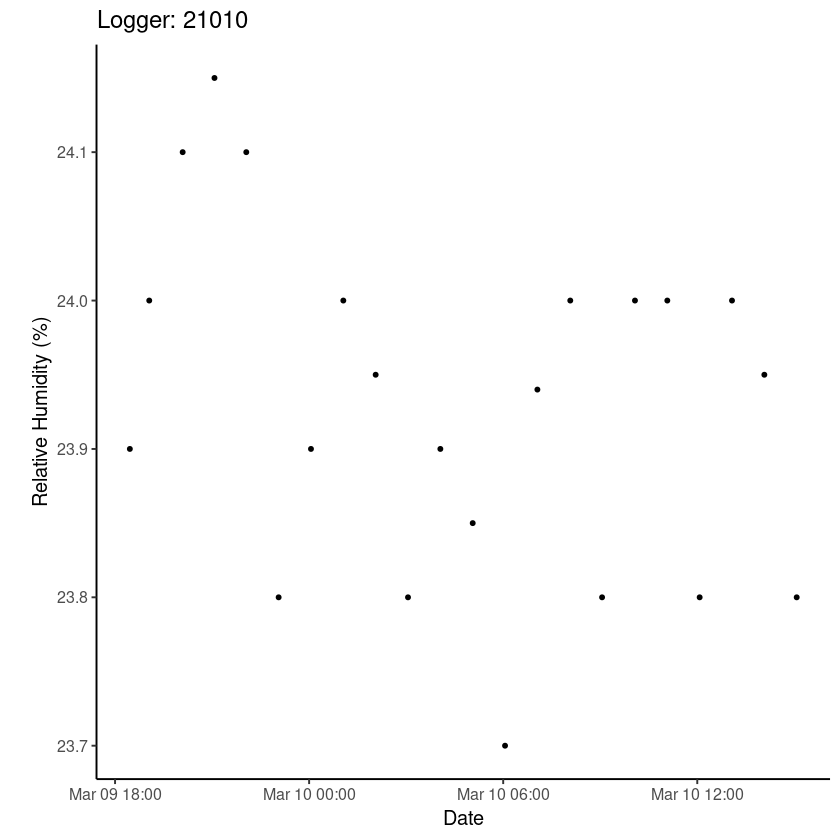

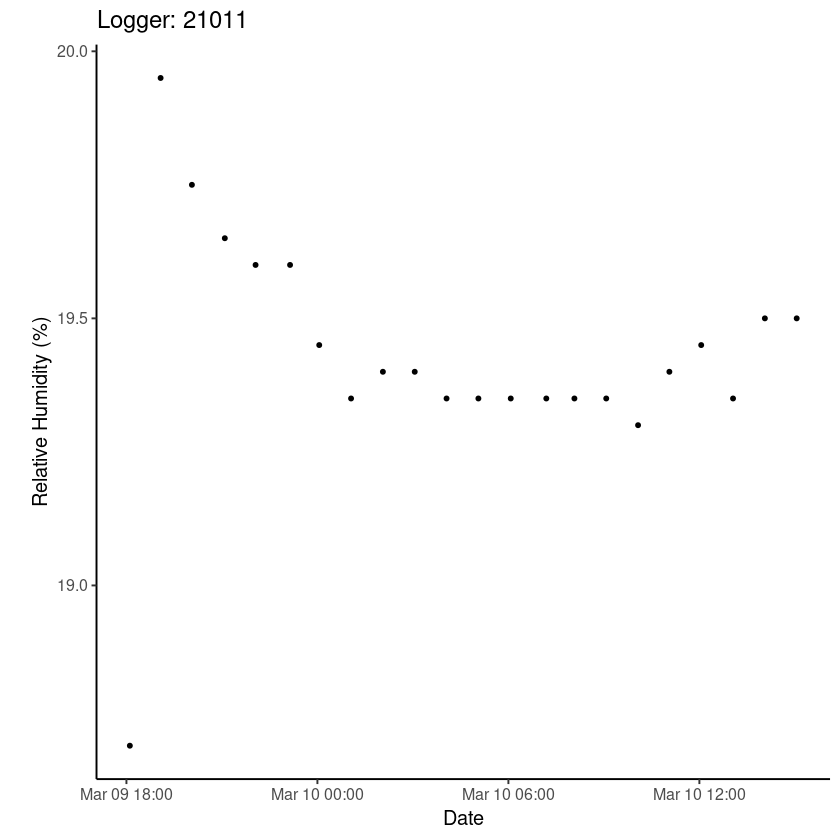

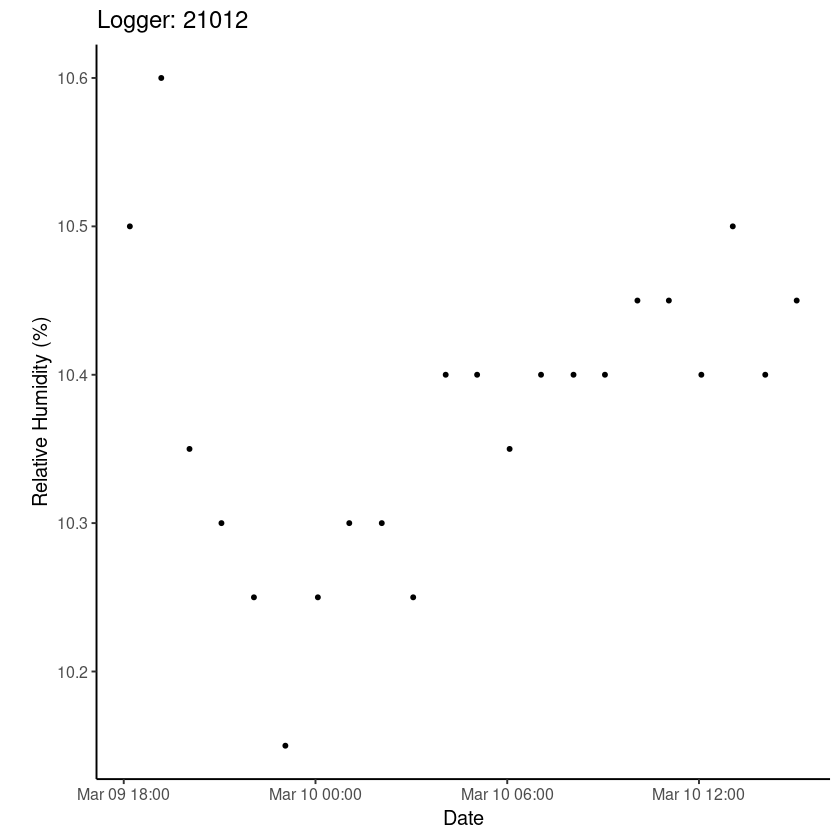

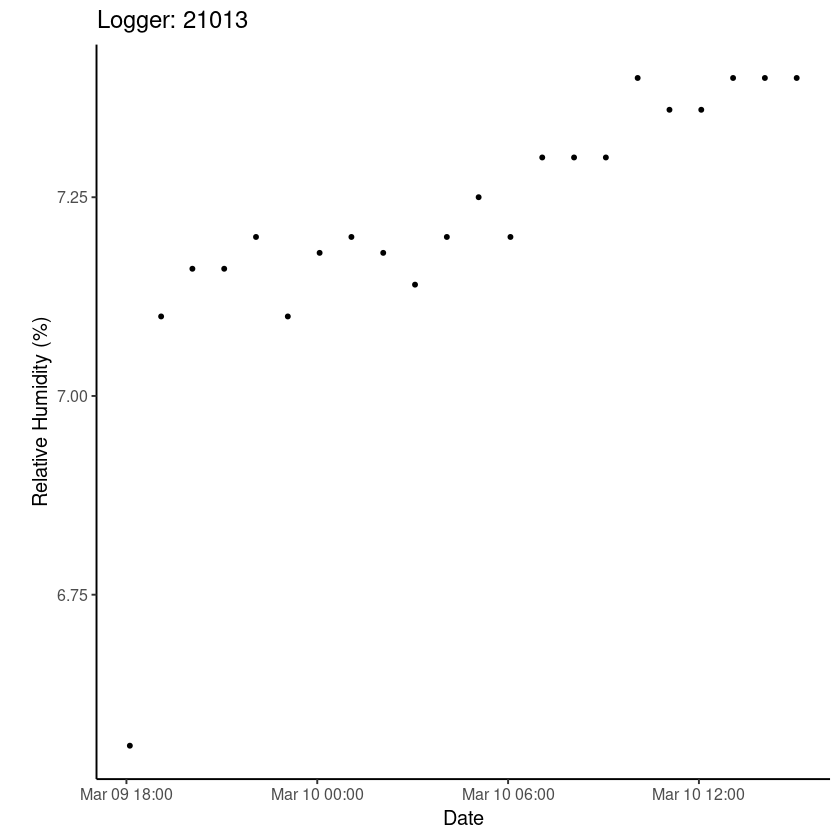

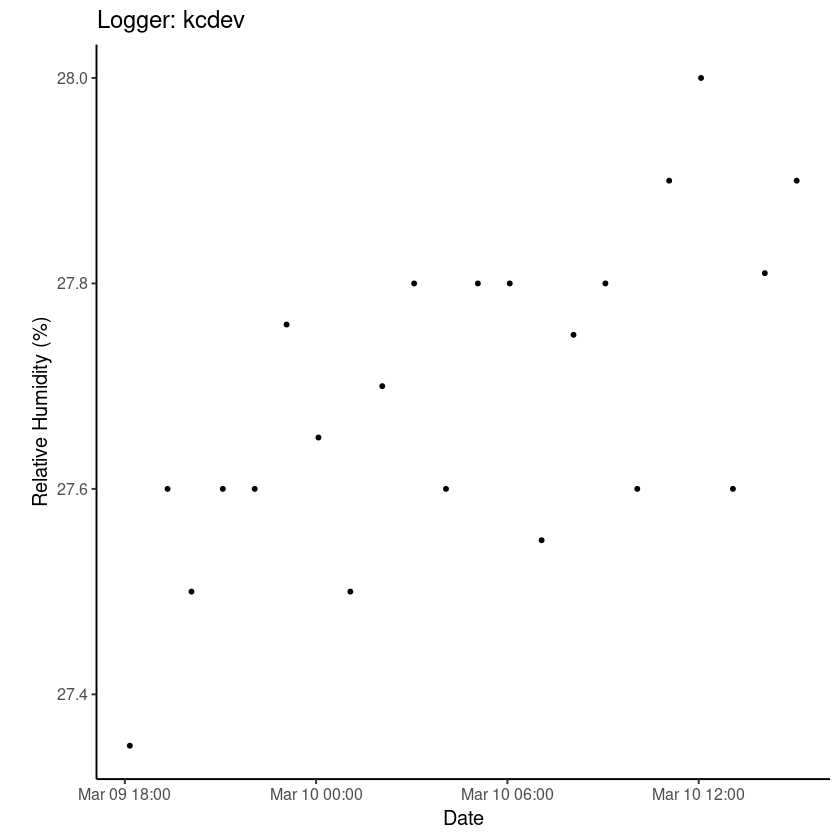

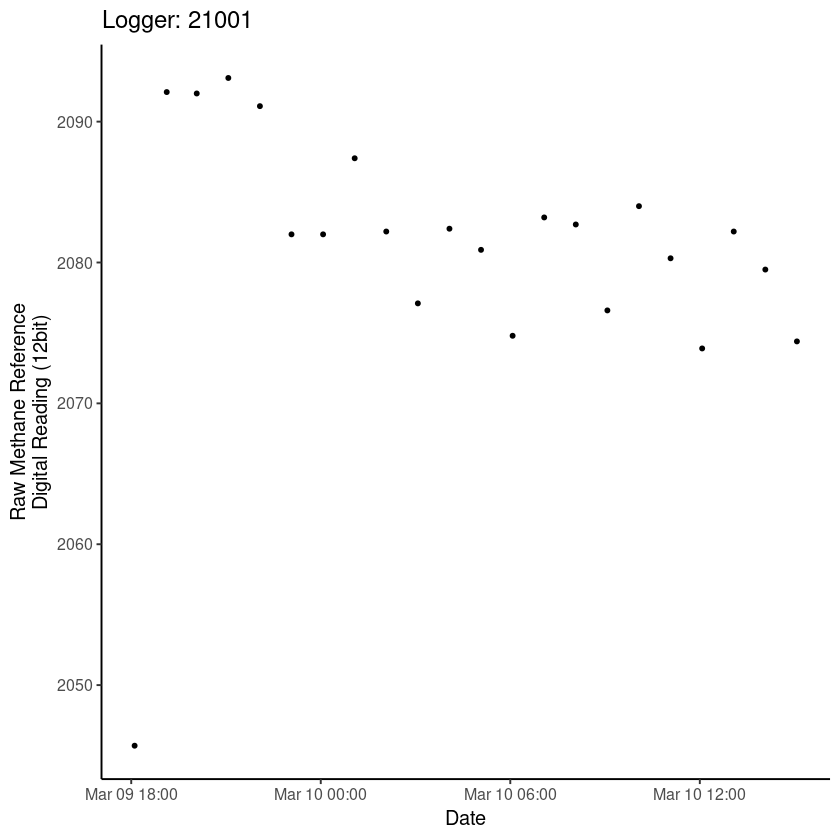

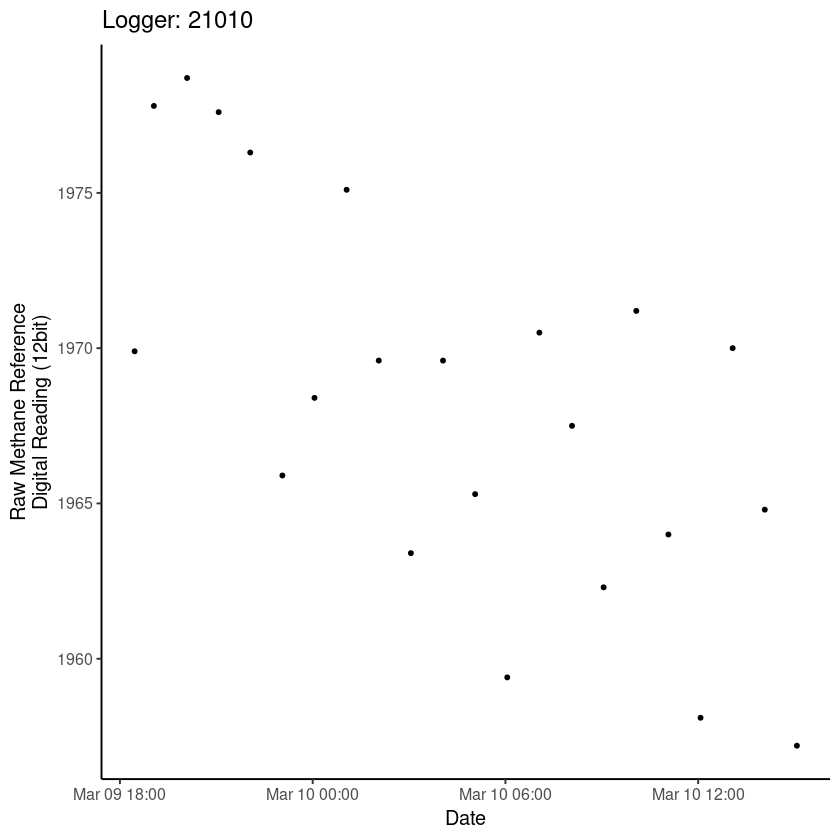

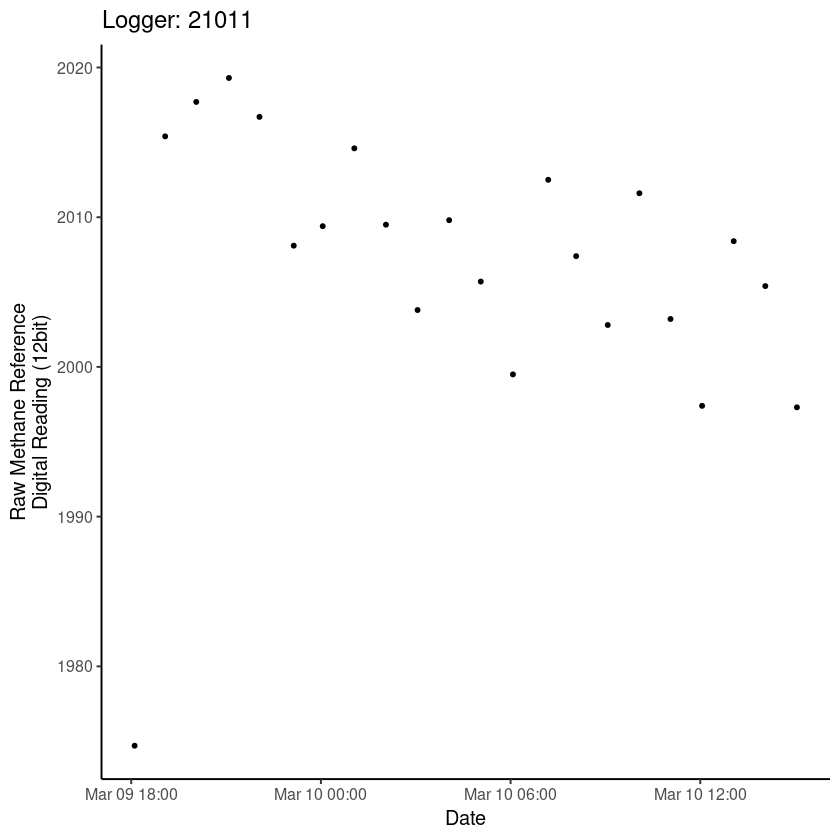

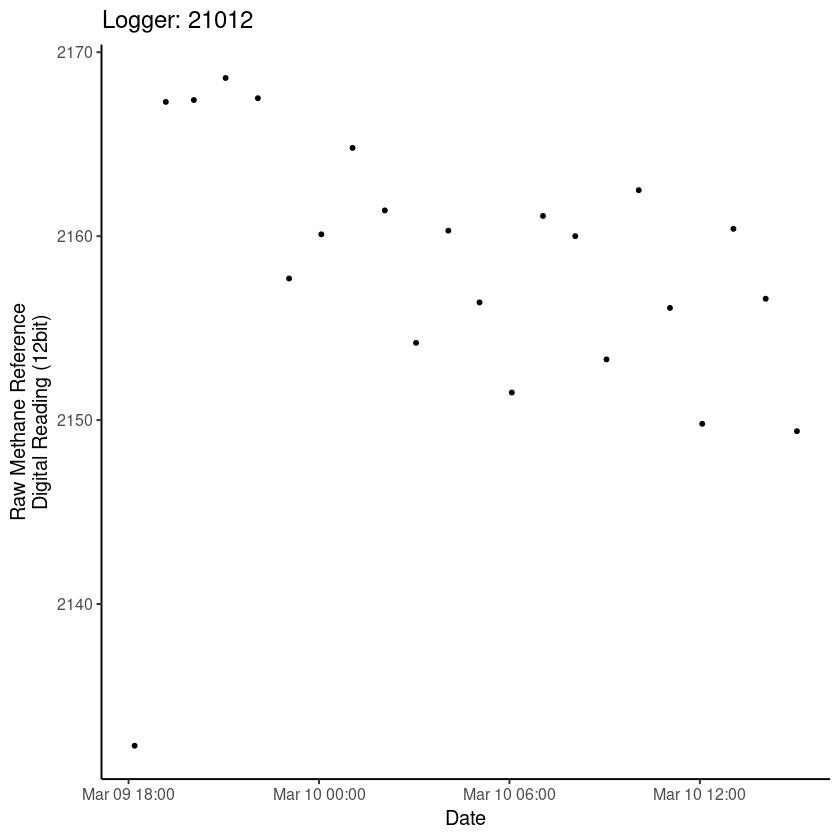

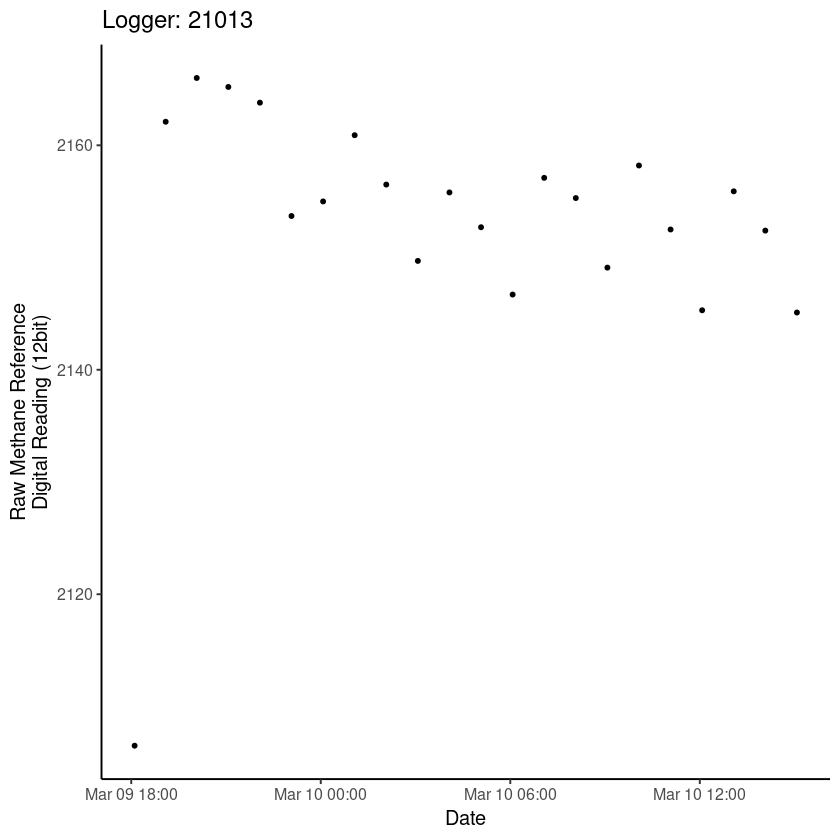

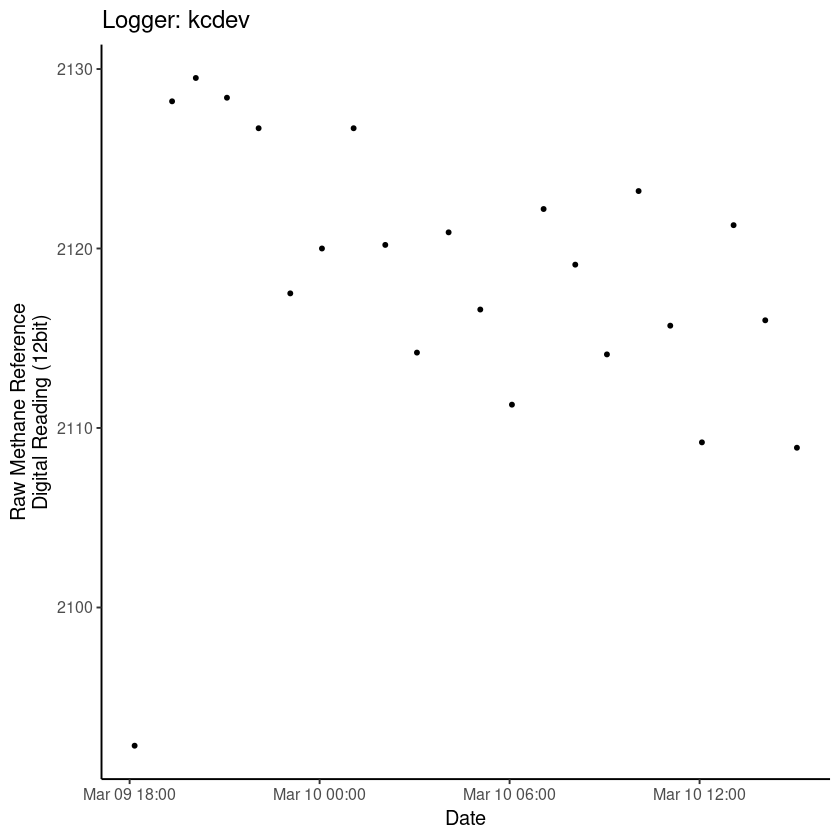

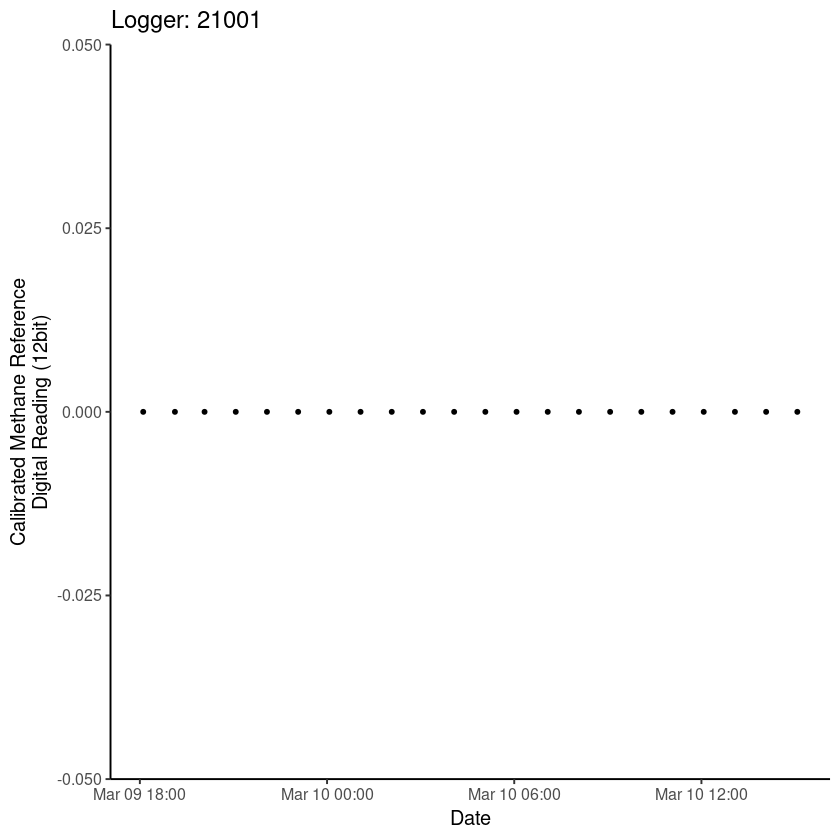

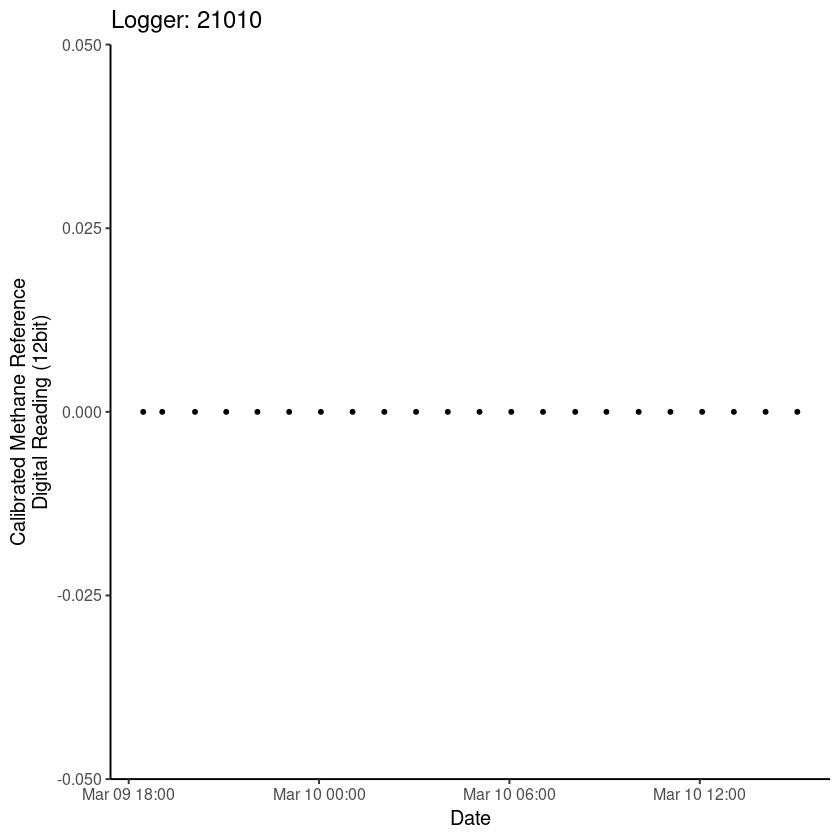

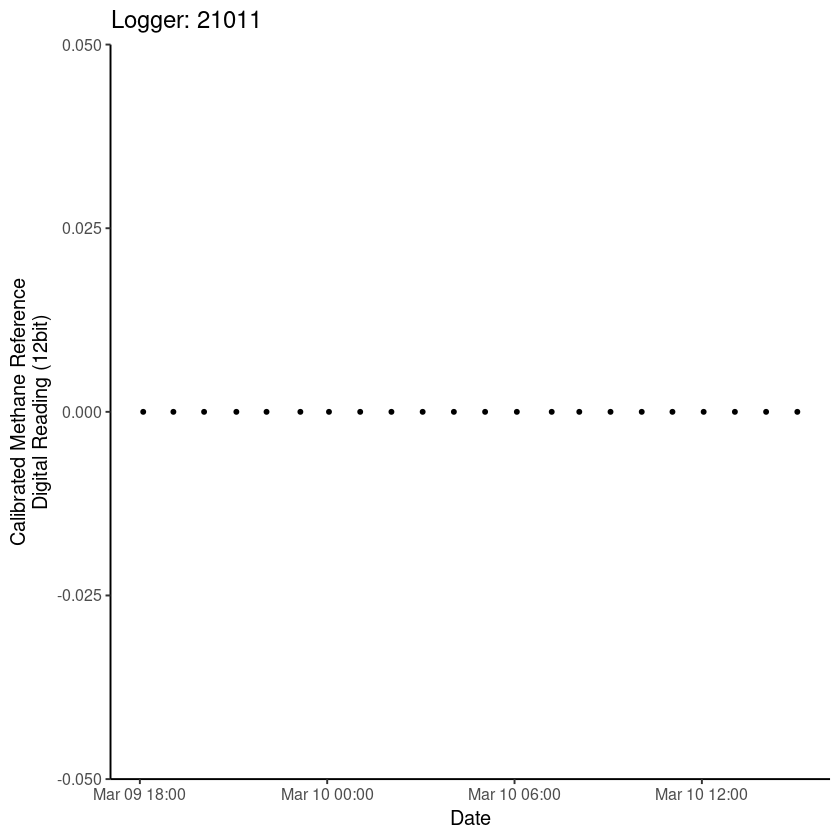

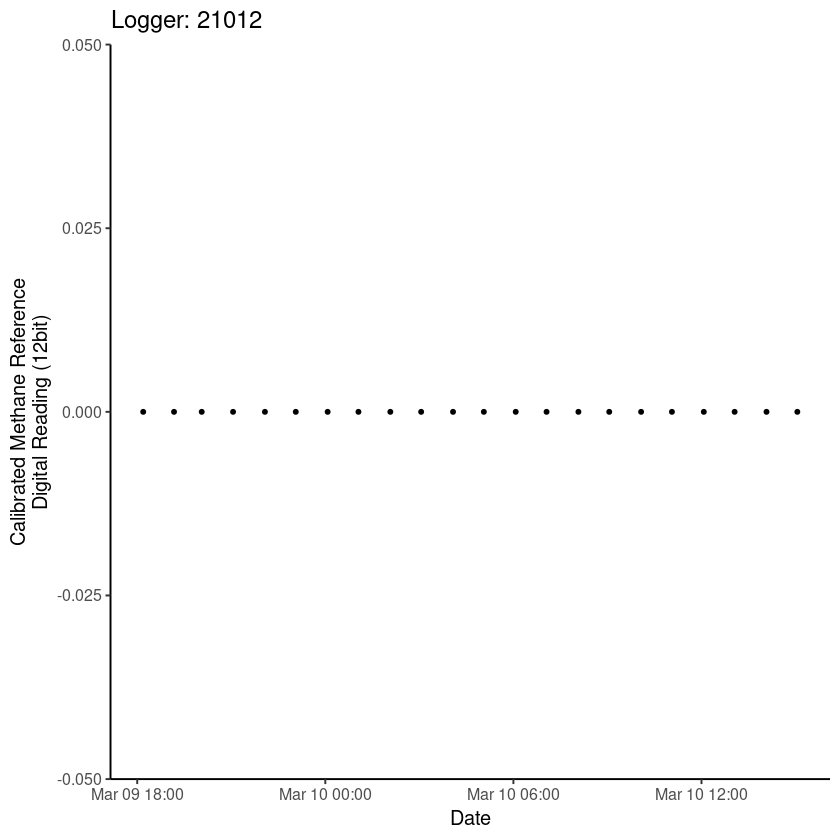

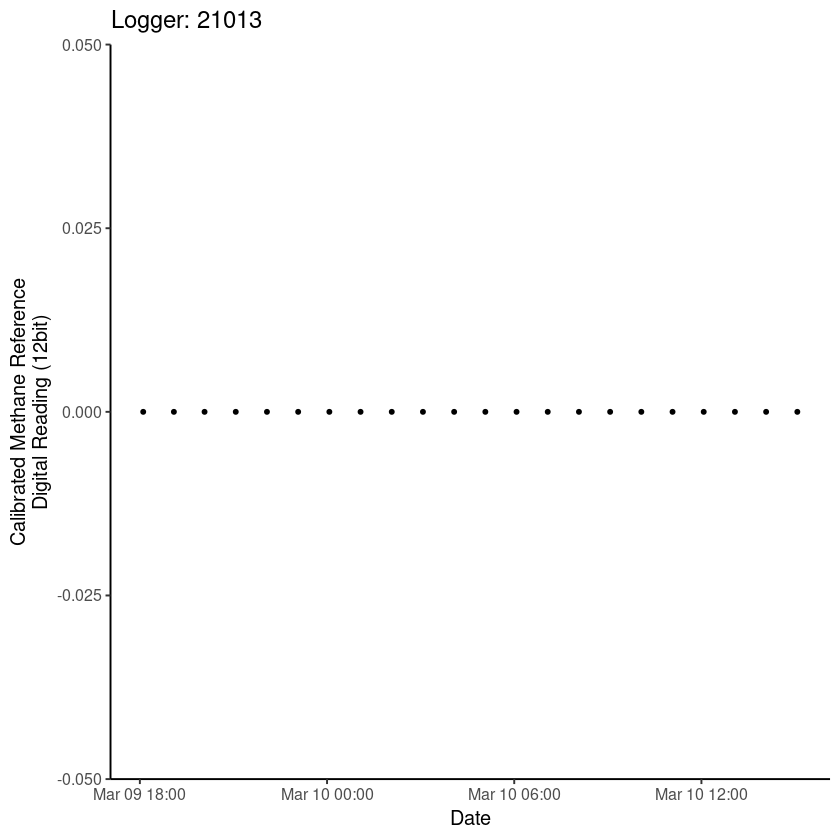

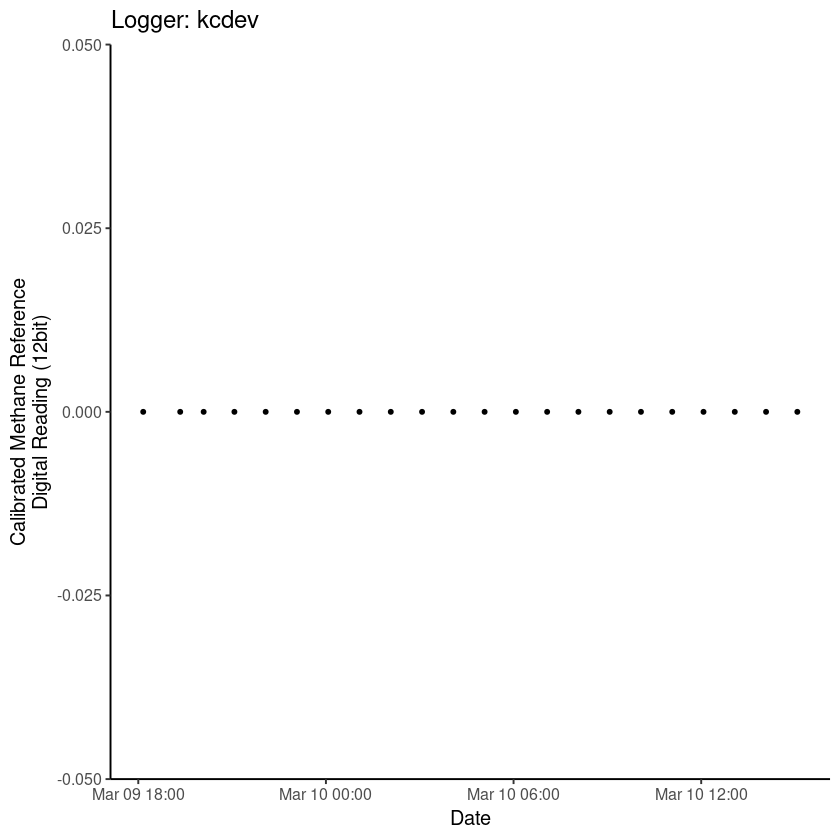

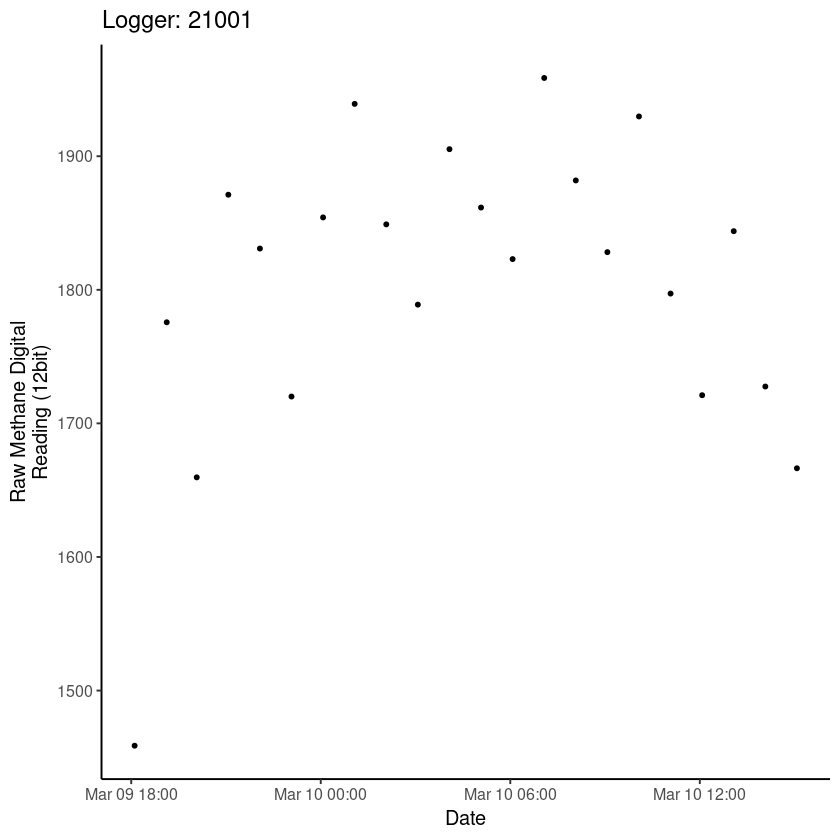

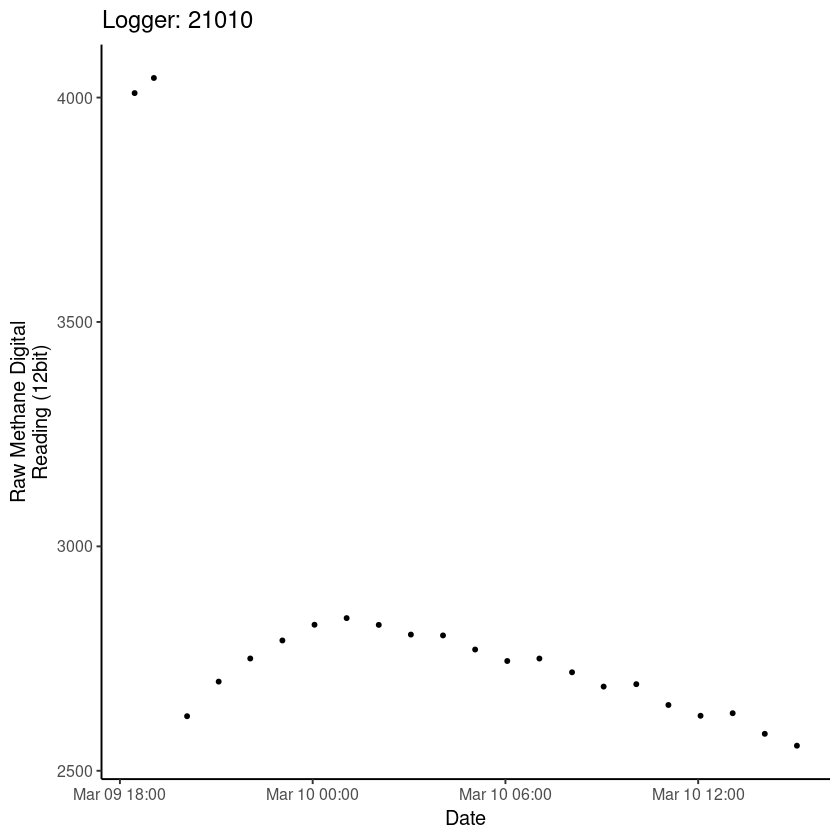

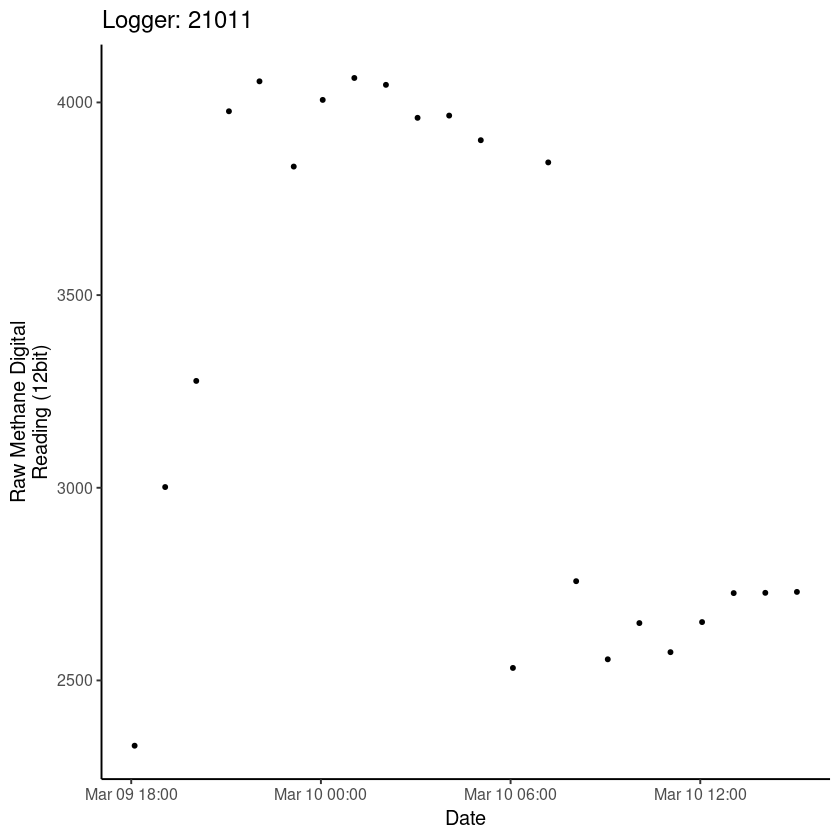

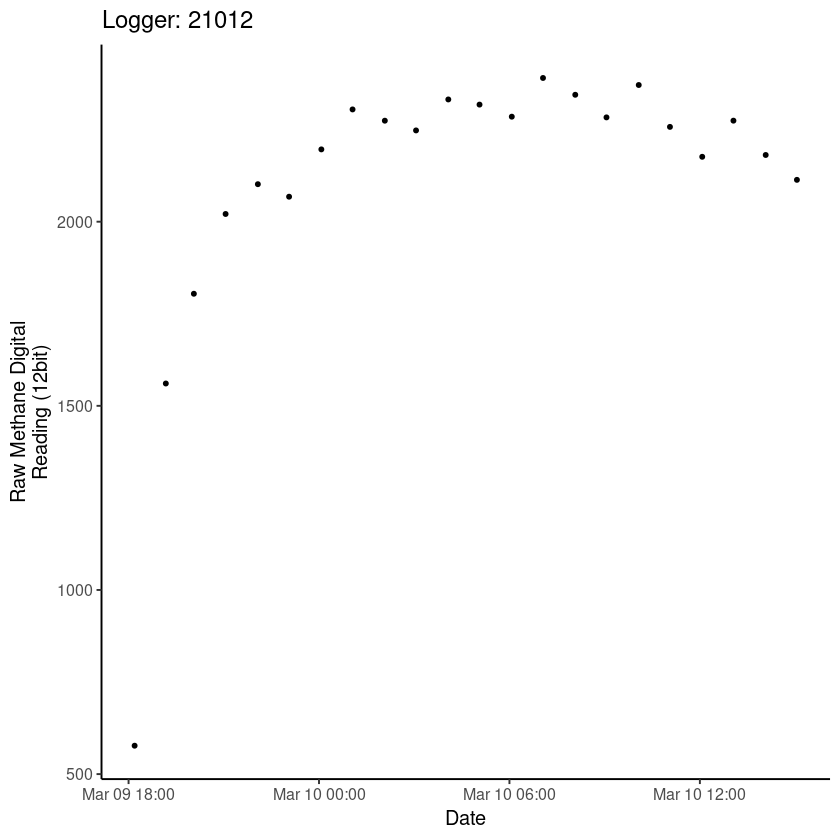

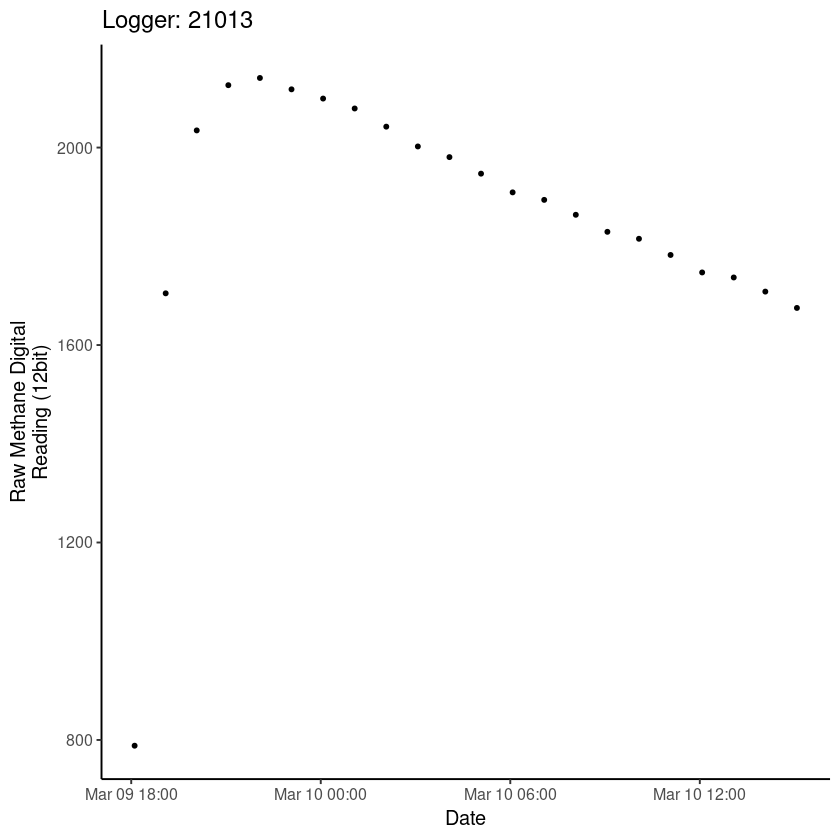

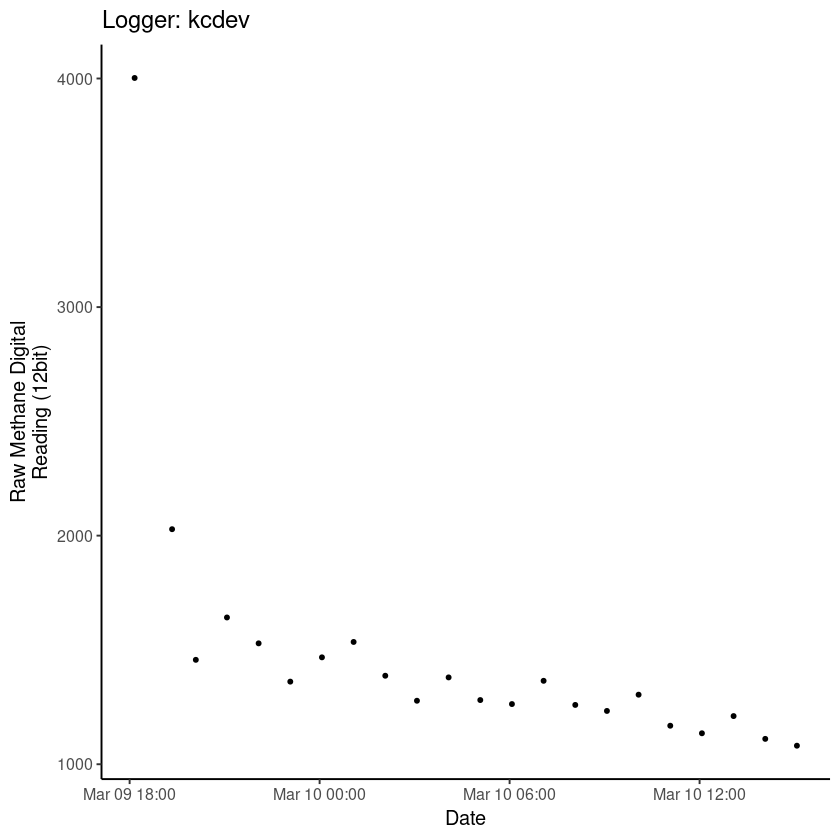

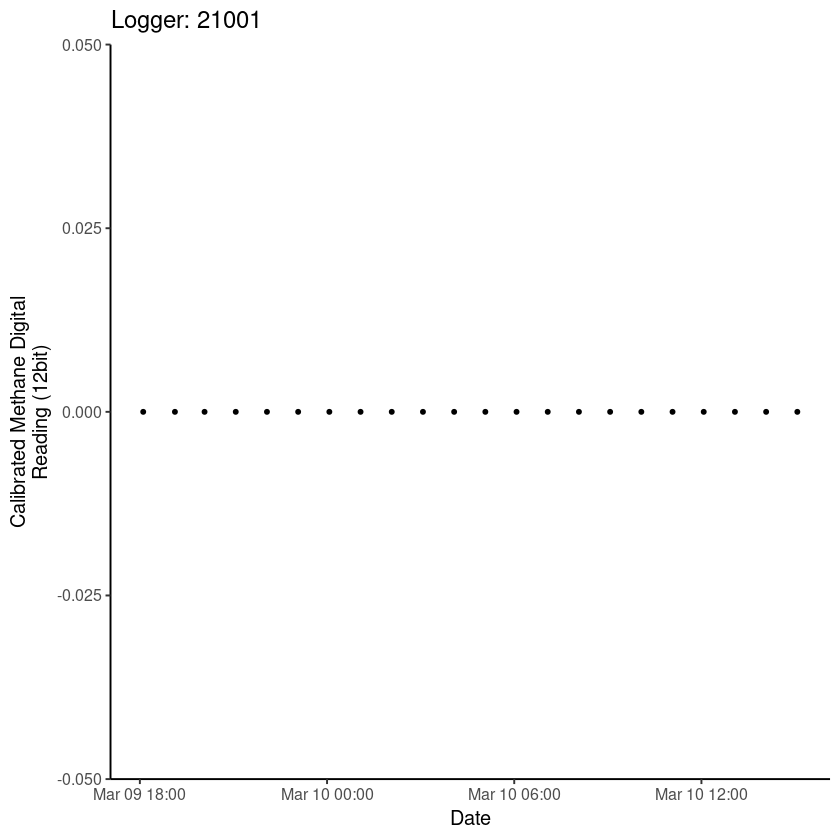

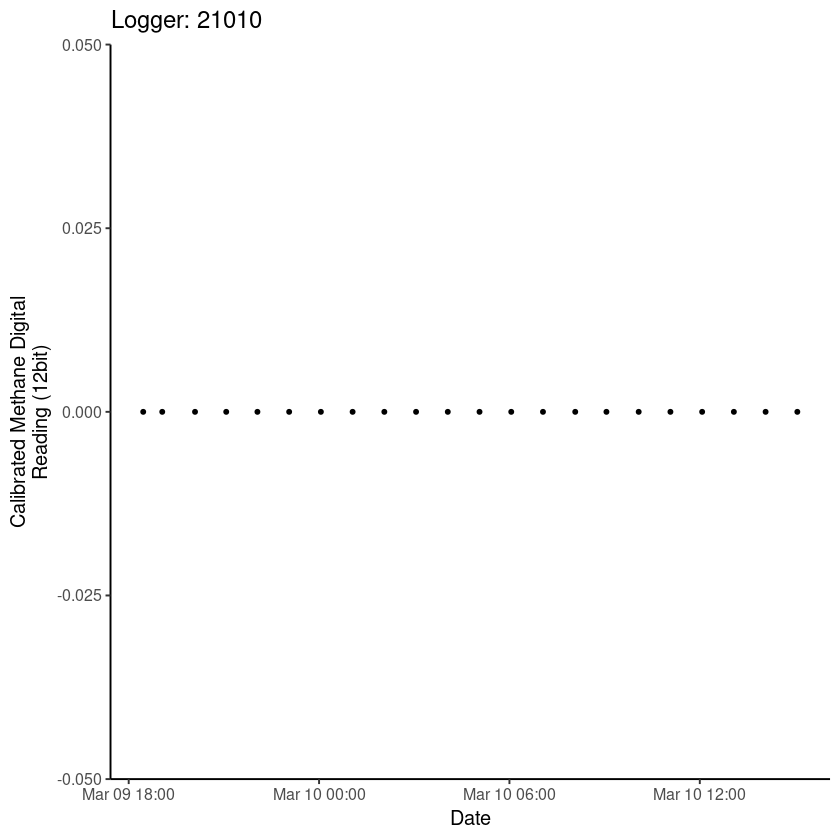

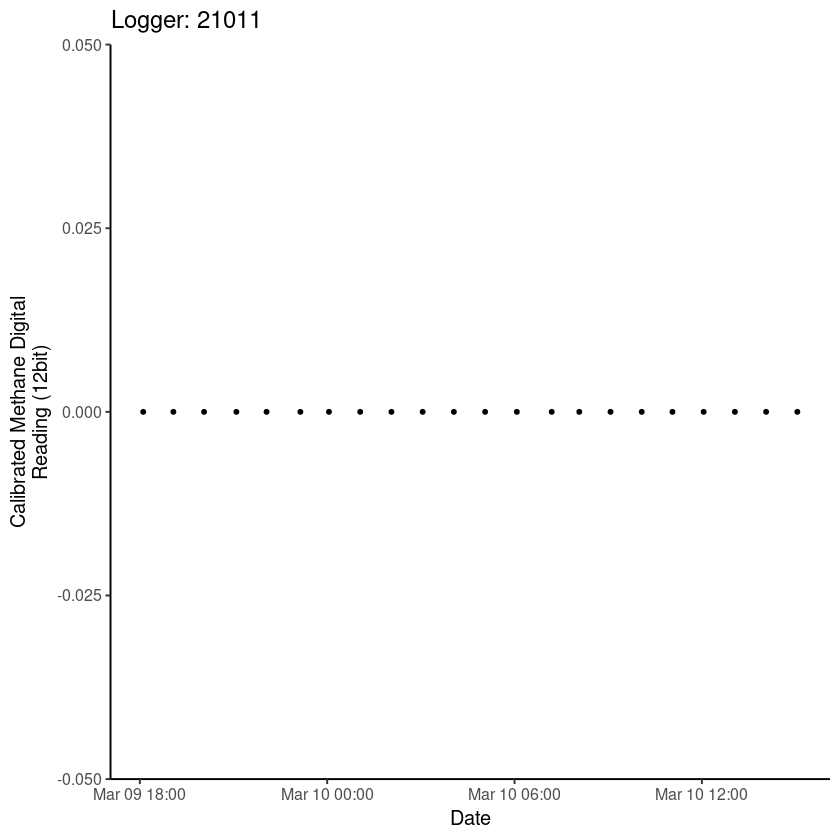

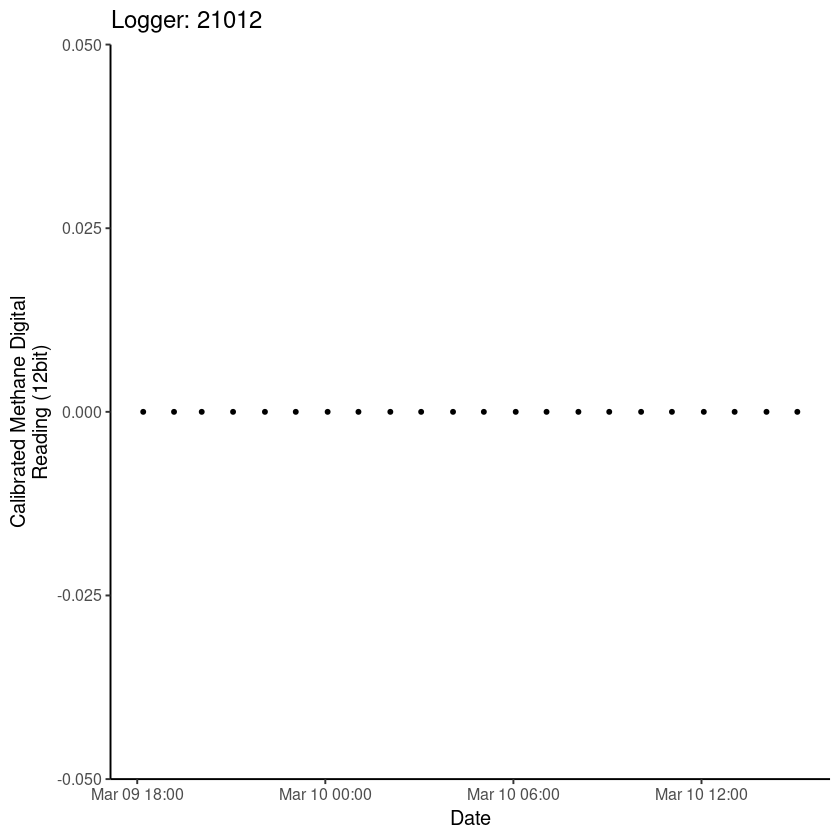

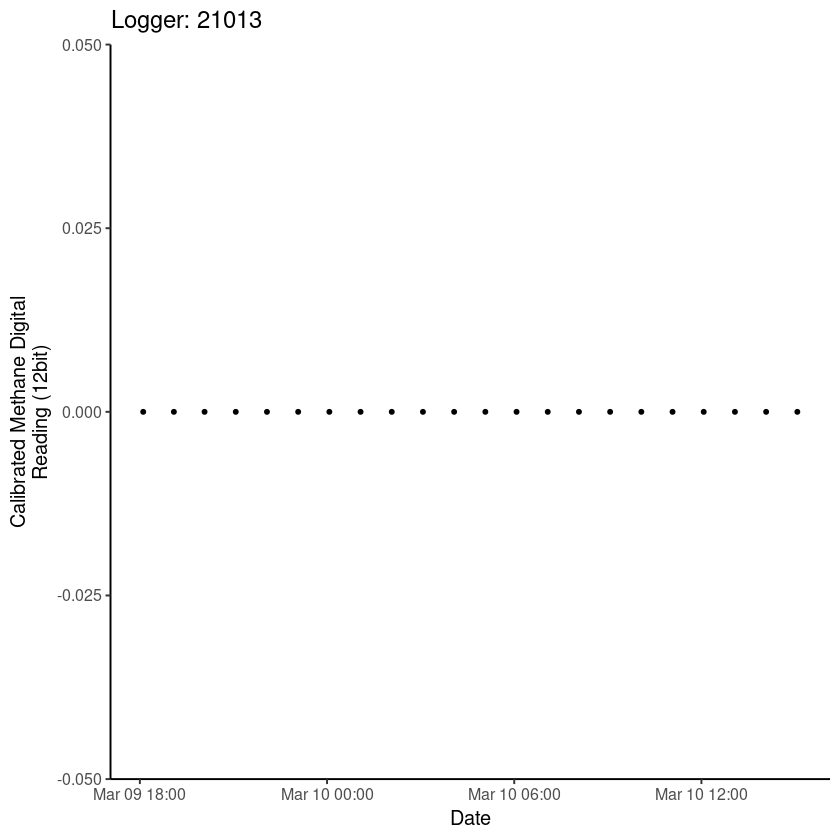

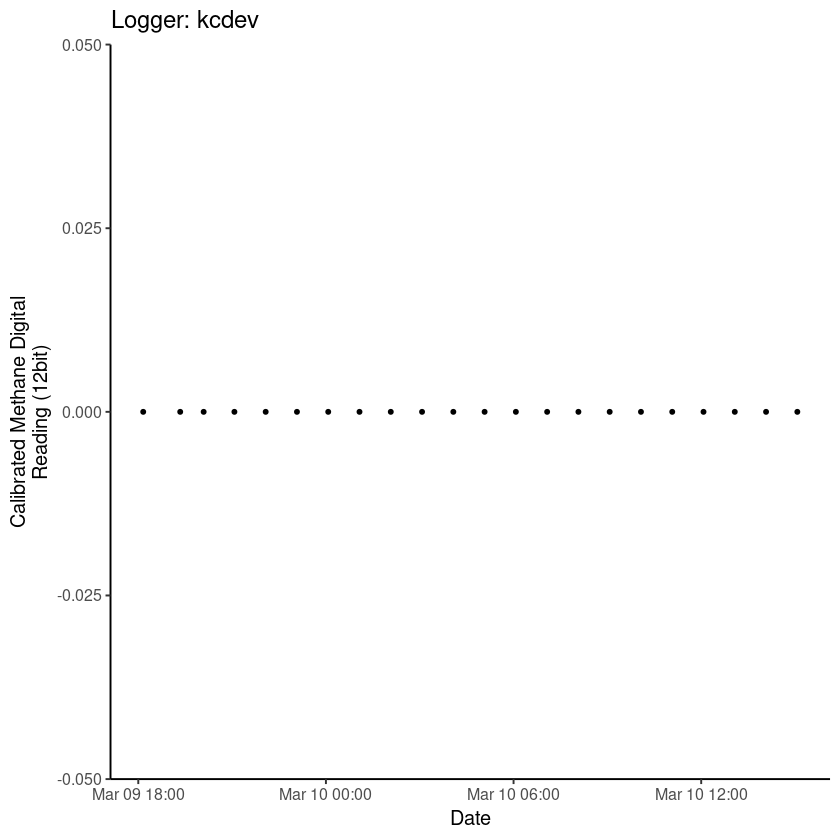

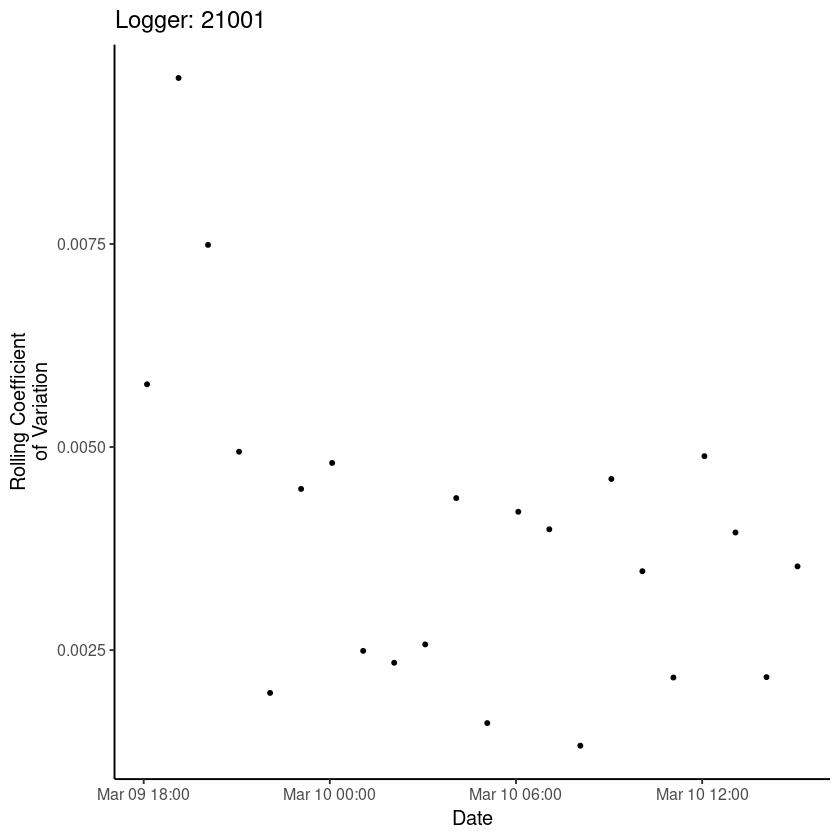

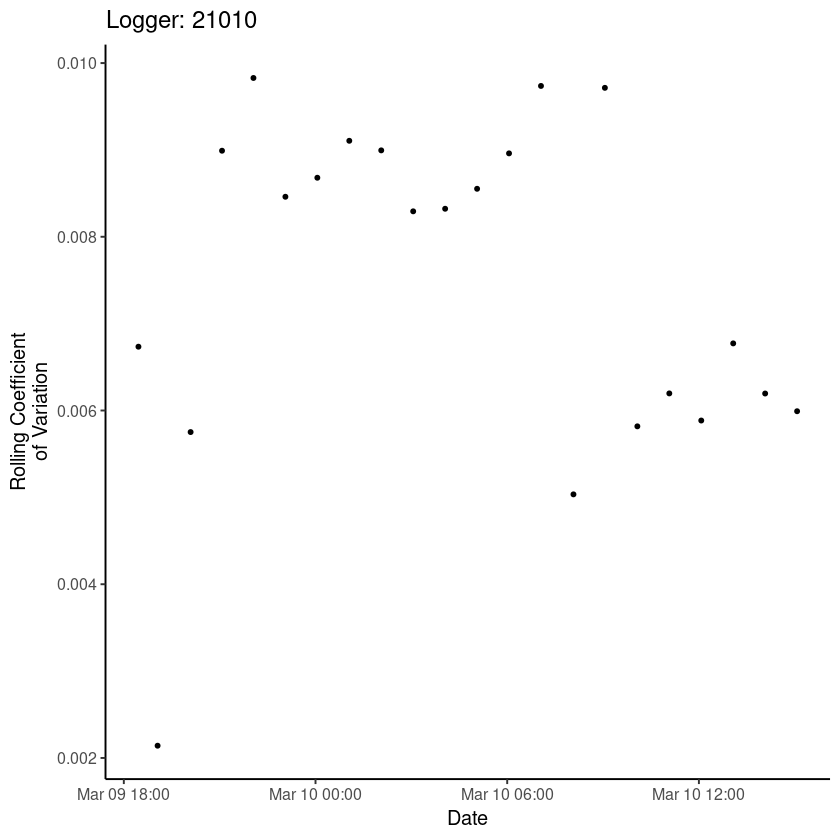

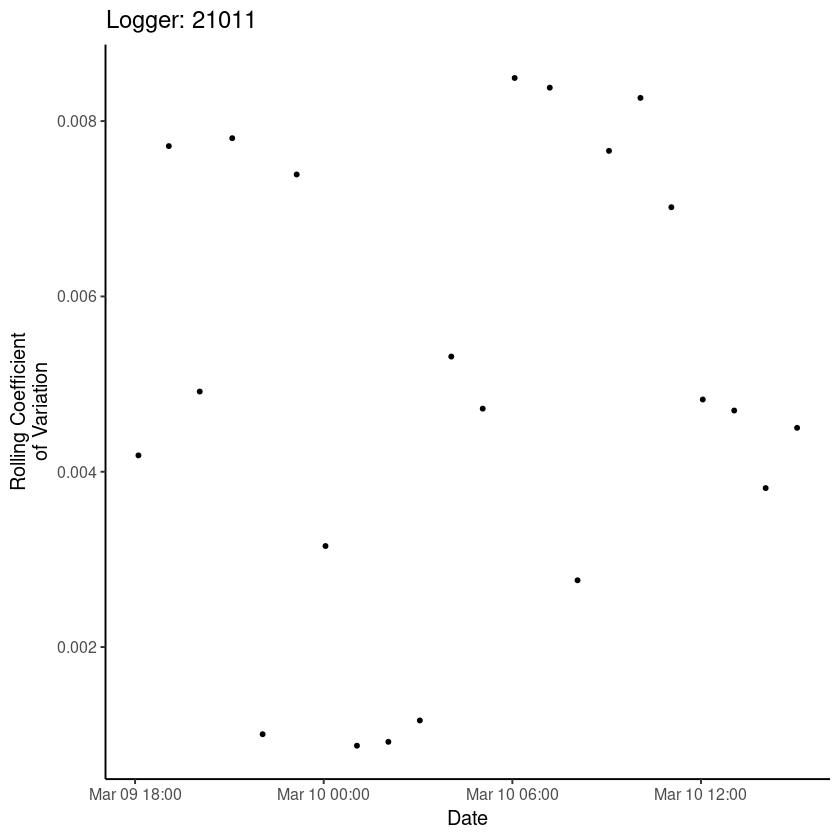

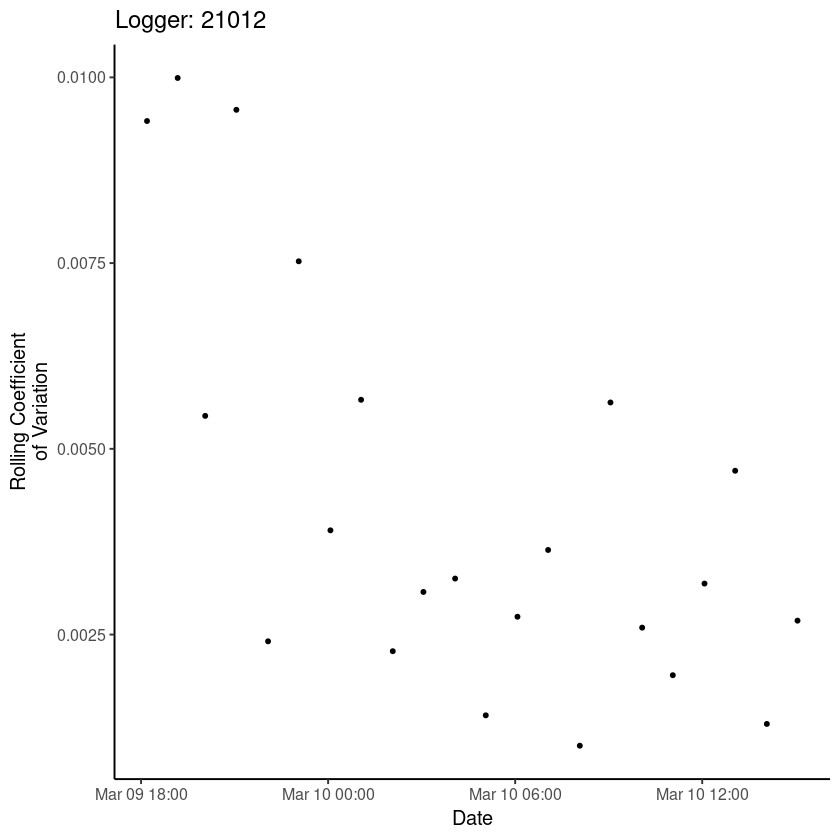

$battery.V
$battery.V$`21010`

$battery.V$`21011`

$battery.V$kcdev

$battery.V$`21012`

$battery.V$`21013`

$battery.V$`21001`


$dht_C
$dht_C$`21010`

$dht_C$`21011`

$dht_C$kcdev

$dht_C$`21012`

$dht_C$`21013`

$dht_C$`21001`


$dht_RH
$dht_RH$`21010`

$dht_RH$`21011`

$dht_RH$kcdev

$dht_RH$`21012`

$dht_RH$`21013`

$dht_RH$`21001`


$ch4rf_raw
$ch4rf_raw$`21010`

$ch4rf_raw$`21011`

$ch4rf_raw$kcdev

$ch4rf_raw$`21012`

$ch4rf_raw$`21013`

$ch4rf_raw$`21001`


$ch4rf_cal
$ch4rf_cal$`21010`

$ch4rf_cal$`21011`

$ch4rf_cal$kcdev

$ch4rf_cal$`21012`

$ch4rf_cal$`21013`

$ch4rf_cal$`21001`


$ch4_raw
$ch4_raw$`21010`

$ch4_raw$`21011`

$ch4_raw$kcdev

$ch4_raw$`21012`

$ch4_raw$`21013`

$ch4_raw$`21001`


$ch4_cal
$ch4_cal$`21010`

$ch4_cal$`21011`

$ch4_cal$kcdev

$ch4_cal$`21012`

$ch4_cal$`21013`

$ch4_cal$`21001`


$roll_cv
$roll_cv$`21010`

$roll_cv$`21011`

$roll_cv$kcdev

$roll_cv$`21012`

$roll_cv$`21013`

$roll_cv$`21001`



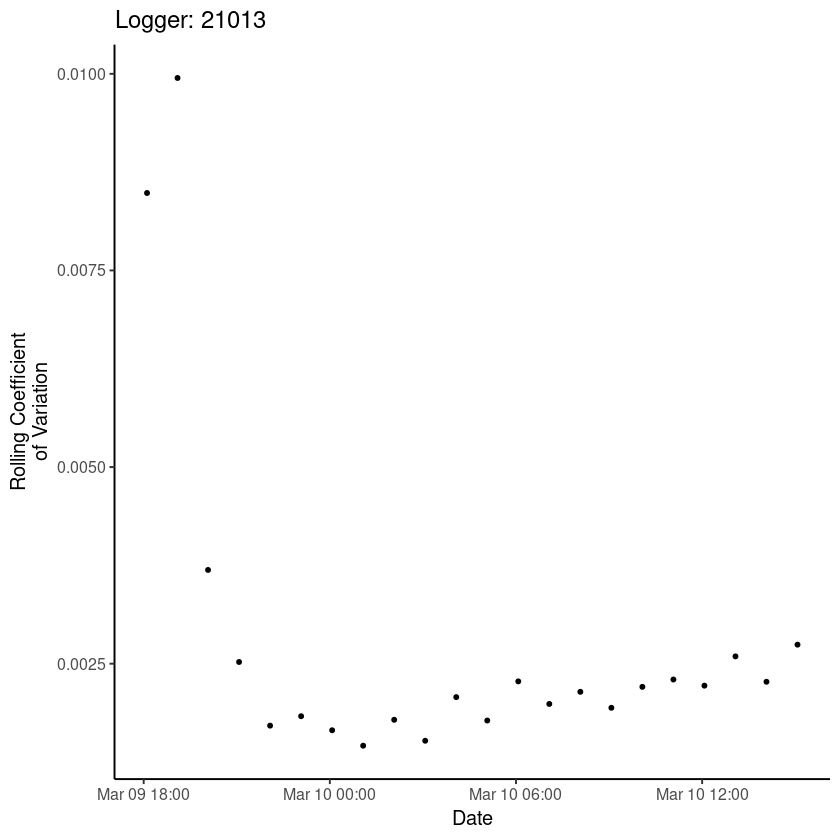

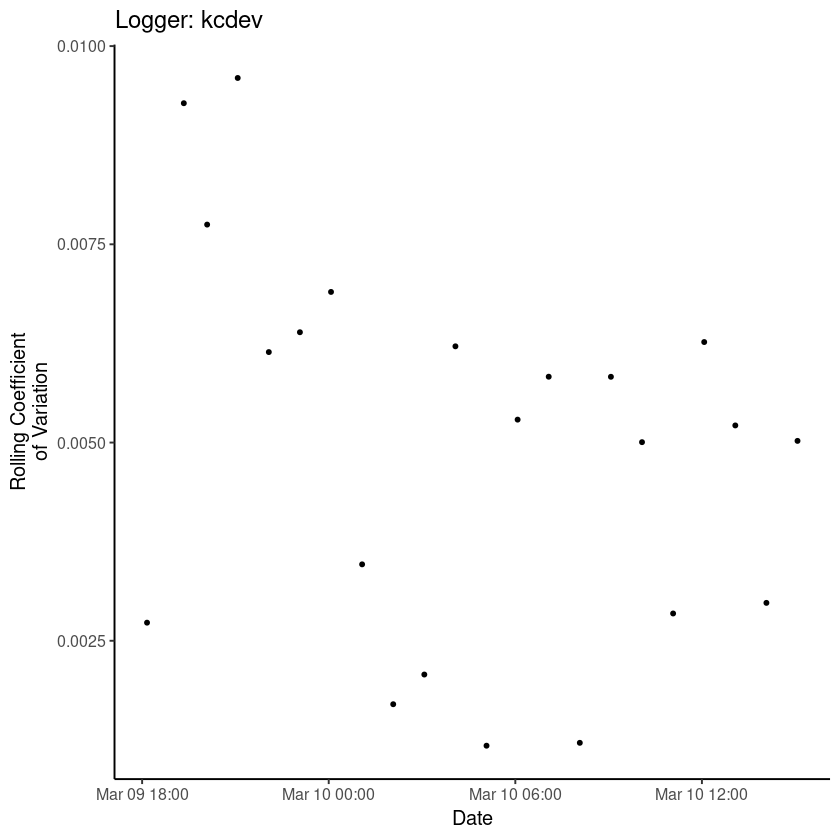

In [37]:
individualPlots<-plot_individual_logger_data_v_time(summary_manualCVdata)

individualPlots

savePlotListList(individualPlots, "ip_manualCV_")